# 데이콘 부동산 허위매물분류 해커톤

(마감: 2025.02.28 23:59)

본 코드의 수행과제는 부동산 데이터에서 허위매물을 예측하는 것입니다.

관련 지식이 있고 ipynb 문서를 열 수 있는 경우, 본 파일을 다운받아서 Outline을 보시면 더 이해가 쉬울 것입니다. 

[코드 개요]

범주형 변수(예: '매물확인방식'은 '전화확인', '현장확인', '서류확인' 중 하나)를 수치화하기 위해, 각 범주의 허위매물 발생빈도를 가중치로 활용하였습니다.(타겟 인코딩)

그 후 데이터가 허위매물보다 정상매물이 훨씬 많은 불균형을 보여, 정상매물을 허위매물만큼 줄이고(Random Undersampling) 변수들의 중요도를 체크하였습니다. (LASSO, Ridge 활용)

위처럼 전처리 후 주로 정형데이터(엑셀에서 흔히 보는 것처럼 구조화된 데이터)에서 강점을 보이는 부스팅 기법 중 하나인 XGBoost를 사용하여 성능을 조정했습니다.

그 결과 매물이 게재된 시점을 뜻하는 '게재일'의 중요도가 높게 나와서, 1달 뿐만이 아니라 15일 혹은 2달 이상의 단위로 성능을 체크했습니다. 확인 결과 3달의 성능이 가장 좋았습니다.

특정 시점 이후부터는 성능 향상에 한계가 있었기에, 자동화 모형(Autogluon)을 사용하였습니다.

In [200]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rc # For the font setting

# For the CV functions
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# For the variable selection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# For the missing value imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor

# For the under & over sampling
from imblearn.under_sampling import RandomUnderSampler

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [201]:
# 1. 폰트 매니저 재설정
fm._load_fontmanager()

# 2. 폰트 직접 등록 및 설정
font_path = "C:/Projects/25_dacon_realastate_anomaly/D2Coding-Ver1.3.2.ttf"
fontprop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Malgun Gothic'

# Data preprocessing

## Overlook

In [202]:
train = pd.read_csv('data/train.csv'); test = pd.read_csv('data/test.csv')

In [203]:
# Summary of the 'train' DataFrame
print("Summary of 'train' DataFrame:")
print(train.describe())
print(train.info())

Summary of 'train' DataFrame:
                보증금             월세         전용면적          해당층           총층  \
count  2.452000e+03    2452.000000  1665.000000  2223.000000  2436.000000   
mean   1.574188e+08  380420.065253    27.009628     4.848403     8.052545   
std    1.212794e+08  206425.413601     7.951757     3.543348     4.920112   
min    5.000000e+06       0.000000    17.500000     1.000000     2.000000   
25%    7.500000e+07  200000.000000    19.800000     2.000000     4.000000   
50%    1.325000e+08  380000.000000    26.400000     4.000000     6.000000   
75%    1.890000e+08  550000.000000    32.110000     6.000000    10.000000   
max    4.090000e+08  750000.000000    49.970000    21.000000    21.000000   

                방수          욕실수        총주차대수          관리비       허위매물여부  
count  2436.000000  2434.000000  1756.000000  2452.000000  2452.000000  
mean      1.378079     1.034511    20.332574     5.477977     0.121533  
std       0.485007     0.182575    28.939900     5.631185

In [204]:
# Summary of the 'test' DataFrame
print("\nSummary of 'test' DataFrame:")
print(test.describe())
print(test.info())


Summary of 'test' DataFrame:
                보증금             월세        전용면적         해당층          총층  \
count  6.130000e+02     613.000000  429.000000  563.000000  611.000000   
mean   1.493581e+08  380619.902121   27.763800    4.486679    7.692308   
std    1.089524e+08  208720.676924    8.088812    3.315189    4.643019   
min    8.500000e+06       0.000000   17.500000    1.000000    2.000000   
25%    6.300000e+07  190000.000000   20.360000    2.000000    4.000000   
50%    1.370000e+08  380000.000000   27.220000    3.000000    6.000000   
75%    1.985000e+08  560000.000000   33.050000    5.000000   10.000000   
max    4.595000e+08  750000.000000   49.970000   21.000000   21.000000   

               방수         욕실수       총주차대수         관리비  
count  611.000000  611.000000  438.000000  613.000000  
mean     1.400982    1.034370   20.292237    5.435563  
std      0.490499    0.182327   22.873775    5.221359  
min      1.000000    1.000000    1.000000    0.000000  
25%      1.000000    1.

In [205]:
# Count NA values for each column in the training set
na_counts_train = train.isna().sum()
print("NA counts in training set:")
print(na_counts_train)

NA counts in training set:
ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      787
해당층       229
총층         16
방향          0
방수         16
욕실수        18
주차가능여부      0
총주차대수     696
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
허위매물여부      0
dtype: int64


In [206]:
# Count NA values for each column in the test set
na_counts_test = test.isna().sum()
print("\nNA counts in test set:")
print(na_counts_test)


NA counts in test set:
ID          0
매물확인방식      0
보증금         0
월세          0
전용면적      184
해당층        50
총층          2
방향          0
방수          2
욕실수         2
주차가능여부      0
총주차대수     175
관리비         0
중개사무소       0
제공플랫폼       0
게재일         0
dtype: int64


In [207]:
# Calculate the ratio of the label column
label_counts = train['허위매물여부'].value_counts()
label_ratio = label_counts / len(train)
print(label_counts)
print(label_ratio)

허위매물여부
0    2154
1     298
Name: count, dtype: int64
허위매물여부
0    0.878467
1    0.121533
Name: count, dtype: float64


## 중개사무소

To convert this categorical column into a numerical one properly, Fraud-rate encoding is used.

Each unique value in the '중개사무소' column has its corresponding rate of the fraud. (y=1)


Based on this feature, a newly-derived column can be created.

Some unique values have very small number of occurrence. Fraud rate of these values can be highly biased.

Therefore, a cutoff for applying the fraud-rate encoding required and this will be decided by CV.


All folds of CV should contains all abnormal data since the given data is imbalanced.

If 5 fold CV applied, each folds' data will be balanced one. 

In [208]:
# Check the number of unique values in the '제공플랫폼' column
num_categories_train = train['중개사무소'].nunique()
num_categories_test = test['중개사무소'].nunique()

print(num_categories_train, num_categories_test) # The unique values are too many to use one-hot encoding

279 182


In [209]:
min_occurrence_train = train['중개사무소'].value_counts().min()
min_occurrence_test = test['중개사무소'].value_counts().min()
max_occurrence_train = train['중개사무소'].value_counts().max()
max_occurrence_test = test['중개사무소'].value_counts().max()

print(min_occurrence_train, min_occurrence_test, max_occurrence_train, max_occurrence_test)

1 1 799 215


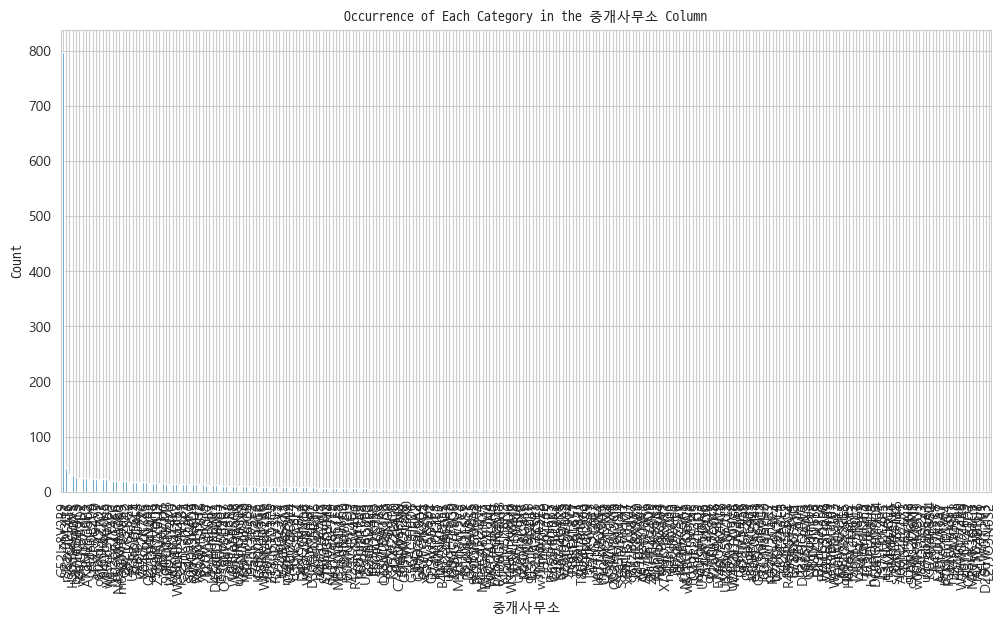

In [210]:
plt.figure(figsize=(12, 6))
train['중개사무소'].value_counts().plot(kind='bar')

plt.title('Occurrence of Each Category in the 중개사무소 Column', fontproperties=fontprop)
plt.xlabel('중개사무소', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.show()

In [211]:
# Find the maximum occurrence value
max_occurrence_value = train['중개사무소'].value_counts().max()
print(f"Maximum occurrence value ({max_occurrence_value}) will be hidden in the plot below.")

# Filter out the maximum occurrence value
filtered_data = train['중개사무소'].value_counts()[train['중개사무소'].value_counts() < max_occurrence_value]

Maximum occurrence value (799) will be hidden in the plot below.


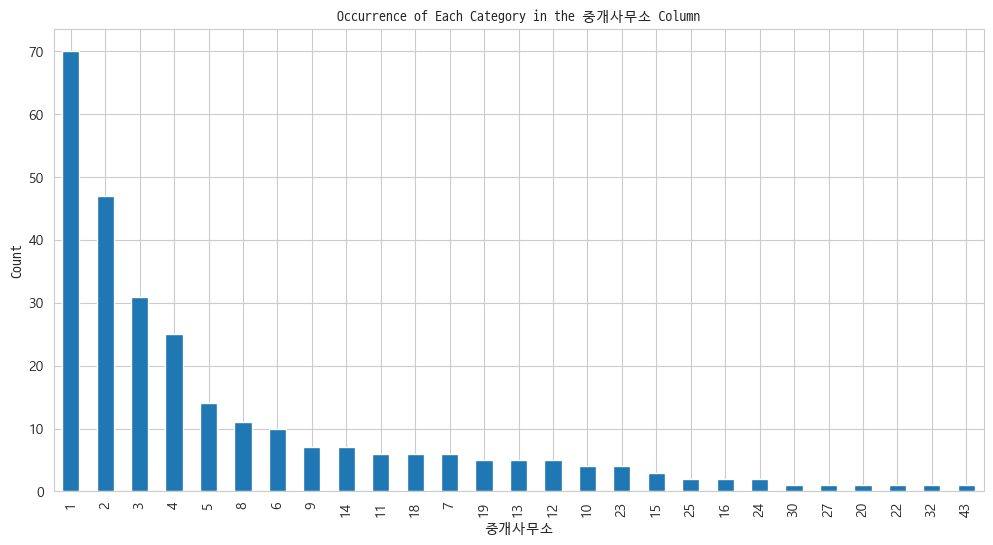

In [212]:
# Plotting code
plt.figure(figsize=(12, 6))
filtered_data.value_counts().plot(kind='bar')
plt.title('Occurrence of Each Category in the 중개사무소 Column', fontproperties=fontprop)
plt.xlabel('중개사무소', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.show()

In [213]:
# Sorted occurrence of each category in the 중개사무소 column for the train dataset
sorted_occurrence_train = train['중개사무소'].value_counts().sort_values(ascending=False)
print("Sorted occurrence of each category in the 중개사무소 column for the train dataset:")
print(sorted_occurrence_train.to_string())

Sorted occurrence of each category in the 중개사무소 column for the train dataset:
중개사무소
G52Iz8V2B9    799
r82ax9M3U3     43
J52gJ2E4T6     32
H90uE4C0W5     30
b87Td0W4Y3     27
z40LO7P9C9     25
w37Qk3B9D2     25
A72Mx9C8U2     24
K86UF7I0P3     24
z54Fl0B2P9     23
a15xR3G4V0     23
o80Xg3Q1Q7     23
r16Dr6Z7C3     23
w94Qb4G0K5     22
w85cb3W8U9     20
m69GM9O9B3     19
Q42YF3Y0I2     19
N45gM0M7R0     19
b03oE4G3F6     19
M02bn7Y4P0     19
Z81Jv8Z5G2     18
U93ap2F8Z1     18
Z68ZJ6F6L4     18
f28iD1U4F3     18
K25cF2K7X6     18
Y04yg0T7Z5     18
Q27Pd1N0R1     16
d22DX4Y4P8     16
S12iP7V0Q9     15
Z78BN7Z0U2     15
S69fV9Z3J7     15
S00TK4T8K2     14
S30er7F3P4     14
k52HR5N1Z1     14
W88DA3W2Q3     14
W02qh9Z4E0     14
j90UQ8N6M3     14
g44jq5J7D0     14
S14na8Q8K2     13
S06Ox3K4D9     13
C41wx1K6U9     13
X95Bu4S5H2     13
y86qM5T6T6     13
R20Vy9K9I8     12
J07Zn4B0R7     12
L43HH2L9R7     12
D47oH9N4M3     12
x68FU7B0S3     12
W61Ep0B6G8     11
u92NN7A1E5     11
U38lq5B5A8     1

In [214]:
class AgencyFraudEncoder:
    def __init__(self, min_samples=5):
        self.min_samples = min_samples
        self.encoding_map = {}
        self.global_mean = None

    def fit(self, df, column='중개사무소', target='허위매물여부'):
        self.global_mean = df[target].mean()

        # Create mapping dictionary
        fraud_rates = {}
        for agency in df[column].unique():
            agency_data = df[df[column] == agency]
            count = len(agency_data)
            if count >= self.min_samples:
                fraud_rates[agency] = agency_data[target].mean()
            else:
                fraud_rates[agency] = self.global_mean

        self.encoding_map = fraud_rates
        return self
    
    def transform(self, df, column='중개사무소'):
        return df[column].map(lambda x: self.encoding_map.get(x, self.global_mean))
    
    def save(self, path='agency_encoder.pkl'):
        with open(path, 'wb') as f:
            pickle.dump({'encoding_map': self.encoding_map, 
                        'global_mean': self.global_mean}, f)
    
    def load(self, path='agency_encoder.pkl'):
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.encoding_map = data['encoding_map']
            self.global_mean = data['global_mean']
        return self

In [215]:
# CV function to get the optimal min_samples value
def find_optimal_min_samples_for_agency(df, column='중개사무소', target='허위매물여부', n_splits=5):
    scores = []
    thresholds = range(0, 50, 1)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for threshold in thresholds:
        fold_scores = []

        for train_idx, val_idx in skf.split(df, df[target]):
            # Split data while preserving class distribution
            train_fold = df.iloc[train_idx]
            val_fold = df.iloc[val_idx]

            # Fit encoder on training fold
            encoder = AgencyFraudEncoder(min_samples=threshold)
            encoder.fit(train_fold)

            # Transform both folds
            X_train = encoder.transform(train_fold).values.reshape(-1, 1)
            X_val = encoder.transform(val_fold).values.reshape(-1, 1)
            y_train = train_fold[target]
            y_val = val_fold[target]

            # Train and evaluate
            model = LogisticRegression(class_weight='balanced')
            model.fit(X_train, y_train)
            fold_scores.append(model.score(X_val, y_val))

        scores.append((threshold, np.mean(fold_scores)))

    return max(scores, key=lambda x: x[1])[0]

In [216]:
# Get the optimal min_samples value
optimal_min_for_agency = find_optimal_min_samples_for_agency(train)
print(optimal_min_for_agency)

13


In [217]:
# Usage example
encoder = AgencyFraudEncoder(min_samples=optimal_min_for_agency)

# Fit and transform train data
train['agency_fraud_rate'] = encoder.fit(train).transform(train)

# Save encoder
encoder.save()

# For test data:
encoder = AgencyFraudEncoder().load()
test['agency_fraud_rate'] = encoder.transform(test)

In [218]:
# Drop original column
train = train.drop('중개사무소', axis=1) 
test = test.drop('중개사무소', axis=1) # Same for test data
# Print sample results
print(train[['agency_fraud_rate', '허위매물여부']].head())

   agency_fraud_rate  허위매물여부
0           0.121533       0
1           0.121533       0
2           0.052632       0
3           0.000000       0
4           0.052632       1


## 제공플랫폼

When the '제공플랫폼' column from the train set and the test set are compared, there are some mismatches in occurance of unique values. 

(e.g. 'N플랫폼' is in the test set but not in the training set)

Those mismatching values' names will be converted to '기타플랫폼' in the both data. 

Of course, the fraud rate encoding follows like I did for the '중개사무소' column.

In [219]:
# Unique values in the '제공플랫폼' column
num_unique_platforms_train = train['제공플랫폼'].nunique()
num_unique_platforms_test = test['제공플랫폼'].nunique()

print(num_unique_platforms_train, num_unique_platforms_test) # The number of unique values is moderate -> one-hot encoding or Fraud rate encoding(doing same as '중개사무소')

13 12


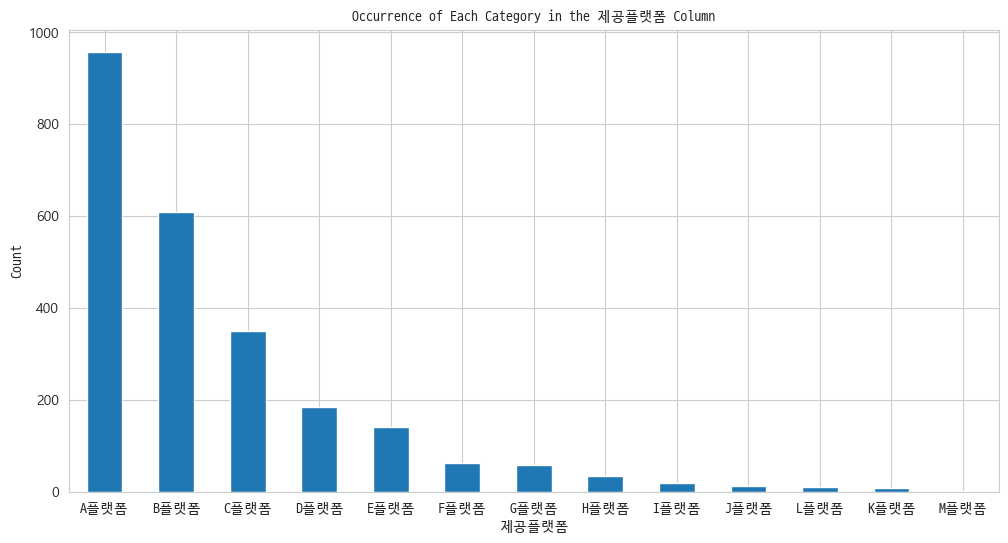

In [220]:
plt.figure(figsize=(12, 6))
train['제공플랫폼'].value_counts().plot(kind='bar')
plt.title('Occurrence of Each Category in the 제공플랫폼 Column', fontproperties=fontprop)
plt.xlabel('제공플랫폼', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

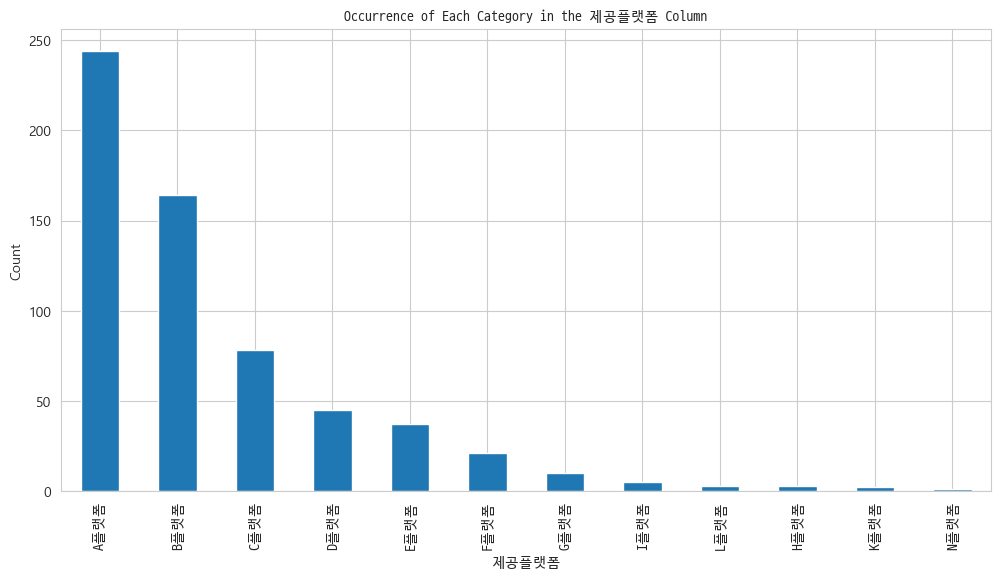

In [221]:
plt.figure(figsize=(12, 6))
test['제공플랫폼'].value_counts().plot(kind='bar')
plt.title('Occurrence of Each Category in the 제공플랫폼 Column', fontproperties=fontprop)
plt.xlabel('제공플랫폼', fontproperties=fontprop)
plt.ylabel('Count')
plt.xticks(rotation=90, fontproperties=fontprop)
plt.show() 

In [222]:
# Values in train but not in test
platforms_train_not_in_test = set(train['제공플랫폼']) - set(test['제공플랫폼'])
print("Values in train but not in test:")
print(platforms_train_not_in_test) # 'J플랫폼', 'M플랫폼' are not in the test set

# Values in test but not in train
platforms_test_not_in_train = set(test['제공플랫폼']) - set(train['제공플랫폼'])
print("Values in test but not in train:")
print(platforms_test_not_in_train) # 'N플랫폼' is not in the training set

Values in train but not in test:
{'J플랫폼', 'M플랫폼'}
Values in test but not in train:
{'N플랫폼'}


In [223]:
# Check the outcome of the replacement
train['제공플랫폼'] = train['제공플랫폼'].replace(platforms_train_not_in_test, '기타플랫폼')
test['제공플랫폼'] = test['제공플랫폼'].replace(platforms_test_not_in_train, '기타플랫폼')
print(train['제공플랫폼'].value_counts())
print(test['제공플랫폼'].value_counts())

제공플랫폼
A플랫폼     958
B플랫폼     610
C플랫폼     350
D플랫폼     184
E플랫폼     142
F플랫폼      63
G플랫폼      59
H플랫폼      34
I플랫폼      20
기타플랫폼     14
L플랫폼      10
K플랫폼       8
Name: count, dtype: int64
제공플랫폼
A플랫폼     244
B플랫폼     164
C플랫폼      78
D플랫폼      45
E플랫폼      37
F플랫폼      21
G플랫폼      10
I플랫폼       5
L플랫폼       3
H플랫폼       3
K플랫폼       2
기타플랫폼      1
Name: count, dtype: int64


In [224]:
class PlatformFraudEncoder:
    def __init__(self, min_samples=5):
        self.min_samples = min_samples # Minimum samples that use global mean value instead of platform-specific fraud rate
        self.encoding_map = {}
        self.global_mean = None

    def fit(self, df, column='제공플랫폼', target='허위매물여부'):
        self.global_mean = df[target].mean()

        # Create mapping dictionary
        fraud_rates = {}
        for platform in df[column].unique():
            platform_data = df[df[column] == platform]
            count = len(platform_data)
            if count >= self.min_samples:
                fraud_rates[platform] = platform_data[target].mean()
            else:
                fraud_rates[platform] = self.global_mean

        self.encoding_map = fraud_rates # Save the encoding map created from the training data
        return self
    
    def transform(self, df, column='제공플랫폼'):
        return df[column].map(lambda x: self.encoding_map.get(x, self.global_mean))
    
    def save(self, path='platform_encoder.pkl'):
        with open(path, 'wb') as f:
            pickle.dump({'encoding_map': self.encoding_map, 
                        'global_mean': self.global_mean}, f)
    
    def load(self, path='platform_encoder.pkl'):
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.encoding_map = data['encoding_map']
            self.global_mean = data['global_mean']
        return self

In [225]:
# CV function to get the optimal min_samples value
def find_optimal_min_samples_for_platform(df, column='제공플랫폼폼', target='허위매물여부', n_splits=5):
    scores = []
    thresholds = range(0, 50, 1)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for threshold in thresholds:
        fold_scores = []

        for train_idx, val_idx in skf.split(df, df[target]):
            # Split data while preserving class distribution
            train_fold = df.iloc[train_idx]
            val_fold = df.iloc[val_idx]

            # Fit encoder on training fold
            encoder = PlatformFraudEncoder(min_samples=threshold)
            encoder.fit(train_fold)

            # Transform both folds
            X_train = encoder.transform(train_fold).values.reshape(-1, 1)
            X_val = encoder.transform(val_fold).values.reshape(-1, 1)
            y_train = train_fold[target]
            y_val = val_fold[target]

            # Train and evaluate
            model = LogisticRegression(class_weight='balanced')
            model.fit(X_train, y_train)
            fold_scores.append(model.score(X_val, y_val))

        scores.append((threshold, np.mean(fold_scores)))

    return max(scores, key=lambda x: x[1])[0]

In [226]:
# Get the optimal min_samples value for the '제공플랫폼' column
optimal_min_for_platform = find_optimal_min_samples_for_platform(train)
print(optimal_min_for_platform)

47


In [227]:
# Usage example
encoder = PlatformFraudEncoder(min_samples=optimal_min_for_platform)
# Fit and transform train data
train['platform_fraud_rate'] = encoder.fit(train).transform(train)
# For test data:
test['platform_fraud_rate'] = encoder.transform(test)

In [228]:
# Drop original column
train = train.drop('제공플랫폼', axis=1) 
test = test.drop('제공플랫폼', axis=1) # Same for test data
# Print sample results
print(train[['platform_fraud_rate', '허위매물여부']].head())

   platform_fraud_rate  허위매물여부
0             0.104918       0
1             0.201087       0
2             0.125261       0
3             0.125261       0
4             0.104918       1


## 매물확인방식

Since there are only 3 unique values in the column, there is no need to set a cutoff.

In [229]:
train['매물확인방식'].value_counts()

매물확인방식
현장확인    1705
전화확인     382
서류확인     365
Name: count, dtype: int64

In [230]:
class checkmethodFraudEncoder:
    def __init__(self, min_samples=5):
        self.min_samples = min_samples # Minimum samples that use global mean value instead of checkmethod-specific fraud rate
        self.encoding_map = {}
        self.global_mean = None

    def fit(self, df, column='매물확인방식', target='허위매물여부'):
        self.global_mean = df[target].mean()

        # Create mapping dictionary
        fraud_rates = {}
        for checkmethod in df[column].unique():
            checkmethod_data = df[df[column] == checkmethod]
            count = len(checkmethod_data)
            if count >= self.min_samples:
                fraud_rates[checkmethod] = checkmethod_data[target].mean()
            else:
                fraud_rates[checkmethod] = self.global_mean

        self.encoding_map = fraud_rates # Save the encoding map created from the training data
        return self
    
    def transform(self, df, column='매물확인방식'):
        return df[column].map(lambda x: self.encoding_map.get(x, self.global_mean))
    
    def save(self, path='checkmethod_encoder.pkl'):
        with open(path, 'wb') as f:
            pickle.dump({'encoding_map': self.encoding_map, 
                        'global_mean': self.global_mean}, f)
    
    def load(self, path='checkmethod_encoder.pkl'):
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.encoding_map = data['encoding_map']
            self.global_mean = data['global_mean']
        return self

In [231]:
# Usage example
encoder = checkmethodFraudEncoder()
# Fit and transform train data
train['checkmethod_fraud_rate'] = encoder.fit(train).transform(train)
# For test data:
test['checkmethod_fraud_rate'] = encoder.transform(test)

In [232]:
# Drop original column
train = train.drop('매물확인방식', axis=1) 
test = test.drop('매물확인방식', axis=1) # Same for test data
# Print sample results
print(train[['checkmethod_fraud_rate', '허위매물여부']].head())

   checkmethod_fraud_rate  허위매물여부
0                0.131378       0
1                0.131378       0
2                0.094241       0
3                0.131378       0
4                0.131378       1


## 게재일(T.S.)

In [233]:
train['게재일'].head()

0    2024-10-09
1    2024-12-26
2    2024-11-28
3    2024-11-26
4    2024-06-25
Name: 게재일, dtype: object

In [234]:
# Convert '게재일' column to datetime
train['게재일'] = pd.to_datetime(train['게재일'])

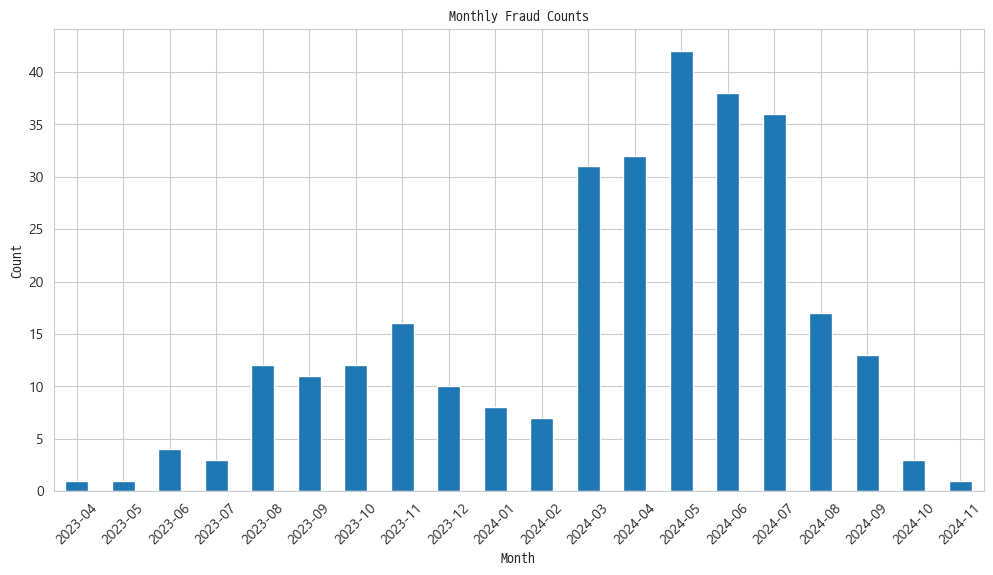

In [235]:
# Count the number of occurrences of '1' in '허위매물여부' for each year and month
fraud_counts = train[train['허위매물여부'] == 1].groupby(train['게재일'].dt.to_period('M')).size()
fraud_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Monthly Fraud Counts', fontproperties=fontprop)
plt.xlabel('Month', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=45)
plt.show()

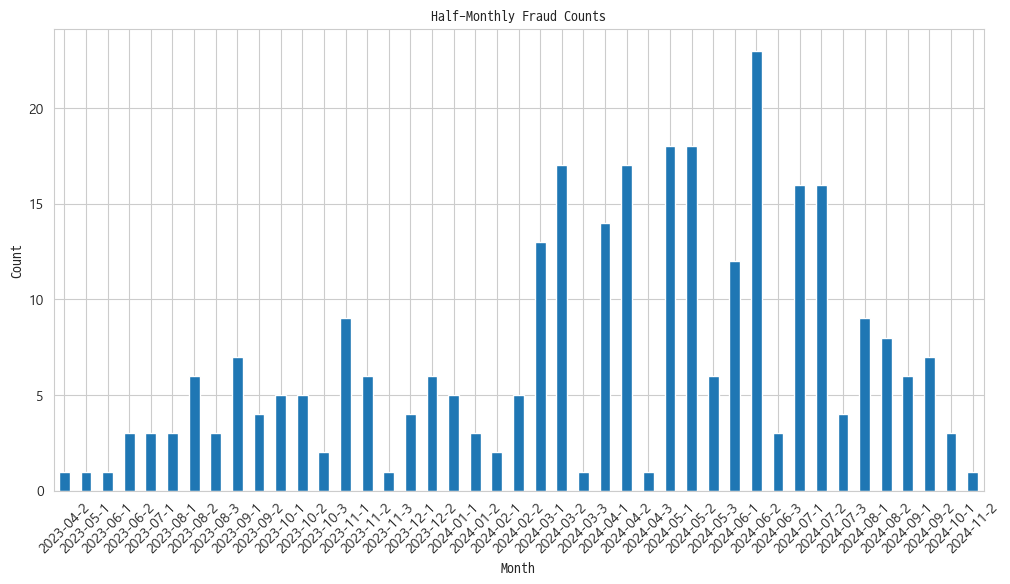

In [236]:
# Create a new column for year and half-month
train['year_half_month'] = train['게재일'].dt.to_period('M').astype(str) + '-' + (train['게재일'].dt.day // 15 + 1).astype(str)

# Count the number of occurrences of '1' in '허위매물여부' for each year and half-month
fraud_counts_half_month = train[train['허위매물여부'] == 1].groupby('year_half_month').size()

fraud_counts_half_month.plot(kind='bar', figsize=(12, 6))
plt.title('Half-Monthly Fraud Counts', fontproperties=fontprop)
plt.xlabel('Month', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=45)
plt.show()

train = train.drop('year_half_month', axis=1)

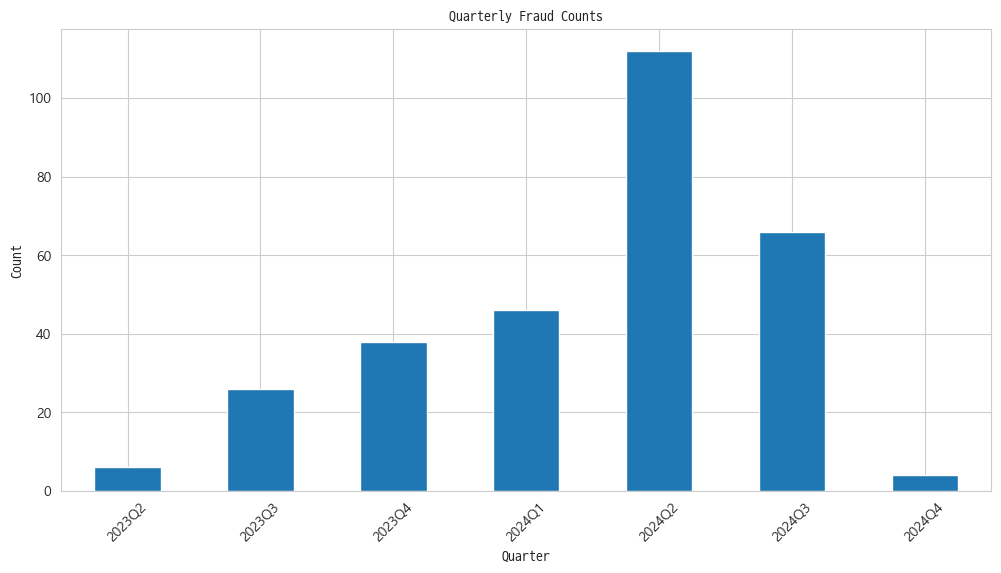

In [237]:
# Create a new column for year and quarter
train['year_quarter'] = train['게재일'].dt.to_period('Q').astype(str)

# Count the number of occurrences of '1' in '허위매물여부' for each year and quarter
fraud_counts_quarter = train[train['허위매물여부'] == 1].groupby('year_quarter').size()

fraud_counts_quarter.plot(kind='bar', figsize=(12, 6))
plt.title('Quarterly Fraud Counts', fontproperties=fontprop)
plt.xlabel('Quarter', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=45)
plt.show()

train = train.drop('year_quarter', axis=1)

In [238]:
class TimeFraudEncoder:
    def __init__(self, window_size=1, min_samples=5, period_type='month'):
        """
        Initialize TimeFraudEncoder
        
        Args:
            window_size (int): Number of periods for rolling window
            min_samples (int): Minimum samples threshold
            period_type (str): Type of period to use ('month', 'half_month', 'two_month', 'quarter', or 'four_month')
        """
        self.window_size = window_size
        self.min_samples = min_samples
        self.monthly_fraud_rates = None
        self.global_mean = None
        self.period_type = period_type
        
    def _get_period(self, dates):
        """
        Helper method to get period string based on selected period type
        
        Args:
            dates: pandas datetime series
        Returns:
            pandas Series of period strings
        """
        if self.period_type == 'month':
            return dates.dt.to_period('M')
        elif self.period_type == 'half_month':
            month_period = dates.dt.to_period('M').astype(str)
            half_month = (dates.dt.day // 15 + 1).astype(str)
            return month_period + '-' + half_month
        elif self.period_type == 'two_month':
            # Create two-month periods (1-2, 3-4, 5-6)
            year = dates.dt.year
            month = dates.dt.month
            two_month_period = ((month - 1) // 2) + 1
            return year.astype(str) + '-' + two_month_period.astype(str)
        elif self.period_type == 'quarter':
            # Create quarterly periods (Q1, Q2, Q3, Q4)
            return dates.dt.to_period('Q')
        elif self.period_type == 'four_month':
            # Create four-month periods (1: Jan-Apr, 2: May-Aug, 3: Sep-Dec)
            year = dates.dt.year
            month = dates.dt.month
            four_month_period = ((month - 1) // 4) + 1
            return year.astype(str) + '-T' + four_month_period.astype(str)
        else:
            raise ValueError("period_type must be 'month', 'half_month', 'two_month', 'quarter', or 'four_month'")
    
    def fit(self, df, date_column='게재일', target='허위매물여부'):
        """
        Fit the encoder on training data
        
        Args:
            df: pandas DataFrame containing the data
            date_column: name of the date column
            target: name of the target column
        Returns:
            self
        """
        # Convert to datetime if not already
        dates = pd.to_datetime(df[date_column])
        
        # Calculate global mean fraud rate
        self.global_mean = df[target].mean()
        
        # Get periods based on selected option
        periods = self._get_period(dates)
        
        # Group by period and calculate fraud rates
        monthly_stats = df.groupby(periods).agg({
            target: ['count', 'mean']
        }).droplevel(0, axis=1)
        monthly_stats.columns = ['count', 'fraud_rate']
        
        # Calculate rolling average fraud rate
        monthly_stats['rolling_fraud_rate'] = monthly_stats['fraud_rate']\
            .rolling(window=self.window_size, min_periods=1, center=True).mean()
            
        # Use global mean for periods with insufficient samples
        monthly_stats['final_rate'] = np.where(
            monthly_stats['count'] >= self.min_samples,
            monthly_stats['rolling_fraud_rate'],
            self.global_mean
        )
        
        self.monthly_fraud_rates = monthly_stats['final_rate']
        return self
    
    def transform(self, df, date_column='게재일'):
        """
        Transform new data using fitted encoder
        
        Args:
            df: pandas DataFrame containing the data
            date_column: name of the date column
        Returns:
            pandas Series of encoded values
        """
        dates = pd.to_datetime(df[date_column])
        periods = self._get_period(dates)
        
        # Map periods to fraud rates, use global mean for unknown periods
        return periods.map(self.monthly_fraud_rates).fillna(self.global_mean)
    
    @staticmethod
    def find_optimal_params(df, date_column='게재일', target='허위매물여부',
                          window_sizes=range(1, 7, 1), min_samples_range=range(1, 10, 1),
                          period_type='month'):
        """
        Find optimal parameters using cross-validation
        
        Args:
            df: pandas DataFrame containing the data
            date_column: name of the date column
            target: name of the target column
            window_sizes: range of window sizes to try
            min_samples_range: range of minimum sample thresholds to try
            period_type: type of period to use ('month', 'half_month', 'two_month', 'quarter', or 'four_month')
        Returns:
            tuple of (optimal_window_size, optimal_min_samples)
        """
        best_score = -np.inf
        best_params = None
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        for window_size in window_sizes:
            for min_samples in min_samples_range:
                fold_scores = []
                
                for train_idx, val_idx in skf.split(df, df[target]):
                    train_fold = df.iloc[train_idx]
                    val_fold = df.iloc[val_idx]
                    
                    encoder = TimeFraudEncoder(window_size=window_size,
                                            min_samples=min_samples,
                                            period_type=period_type)
                    encoder.fit(train_fold)
                    
                    X_train = encoder.transform(train_fold).values.reshape(-1, 1)
                    X_val = encoder.transform(val_fold).values.reshape(-1, 1)
                    y_train = train_fold[target]
                    y_val = val_fold[target]
                    
                    model = LogisticRegression(class_weight='balanced')
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_val)
                    fold_scores.append(f1_score(y_val, y_pred))
                
                avg_score = np.mean(fold_scores)
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = (window_size, min_samples)
        
        return best_params

In [239]:
# Usage example for all period types
period_types = ['month', 'half_month', 'two_month', 'quarter', 'four_month']
results = {}

for period_type in period_types:
    # Find optimal parameters
    window_size, min_samples = TimeFraudEncoder.find_optimal_params(
        train, period_type=period_type
    )
    
    # Create and fit encoder
    encoder = TimeFraudEncoder(
        window_size=window_size,
        min_samples=min_samples,
        period_type=period_type
    )
    encoder.fit(train)
    
    # Transform data
    encoded_values = encoder.transform(train)
    
    # Store results
    results[period_type] = {
        'window_size': window_size,
        'min_samples': min_samples,
        'unique_values': len(encoded_values.unique()),
        'encoded_values': encoded_values
    }
    
    print(f"\nResults for {period_type}:")
    print(f"Optimal window size: {window_size}")
    print(f"Optimal min_samples: {min_samples}")
    print(f"Number of unique values: {len(encoded_values.unique())}")


Results for month:
Optimal window size: 3
Optimal min_samples: 1
Number of unique values: 20

Results for half_month:
Optimal window size: 5
Optimal min_samples: 1
Number of unique values: 47

Results for two_month:
Optimal window size: 5
Optimal min_samples: 1
Number of unique values: 13

Results for quarter:
Optimal window size: 1
Optimal min_samples: 1
Number of unique values: 8

Results for four_month:
Optimal window size: 1
Optimal min_samples: 1
Number of unique values: 7


In [240]:
# Create and fit encoders
# encoder = TimeFraudEncoder(window_size=1, min_samples=1, period_type='four_month')
# train['four_month_fraud_rate'] = encoder.fit(train).transform(train)
# test['four_month_fraud_rate'] = encoder.transform(test)

encoder = TimeFraudEncoder(window_size=1, min_samples=1, period_type='quarter')
train['querter_fraud_rate'] = encoder.fit(train).transform(train)
test['querter_fraud_rate'] = encoder.transform(test)

# encoder = TimeFraudEncoder(window_size=1, min_samples=1, period_type='two_month')
# train['two_month_fraud_rate'] = encoder.fit(train).transform(train)
# test['two_month_fraud_rate'] = encoder.transform(test)

# encoder = TimeFraudEncoder(window_size=5, min_samples=1, period_type='half_month')
# train['half_month_fraud_rate'] = encoder.fit(train).transform(train)
# test['half_month_fraud_rate'] = encoder.transform(test)

# encoder = TimeFraudEncoder(window_size=3, min_samples=1, period_type='month')
# train['month_fraud_rate'] = encoder.fit(train).transform(train)
# test['month_fraud_rate'] = encoder.transform(test)

In [241]:
# Drop unnessary columns
train = train.drop(['게재일'], axis=1)
test = test.drop(['게재일'], axis=1) # Same for test data

## 방향

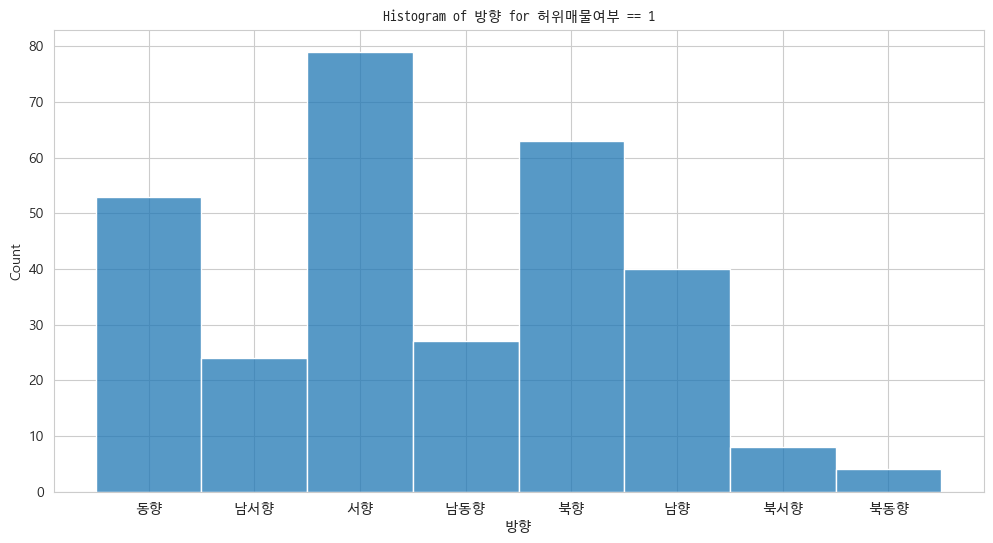

In [242]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 1], x='방향', discrete=True)
plt.title('Histogram of 방향 for 허위매물여부 == 1', fontproperties=fontprop)
plt.xlabel('방향', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.ylabel('Count')
plt.show()
# What contains 'South' shows higher fraud rate
# Simple words such as 'South', 'North' shows higher fraud rate

### Feature deriving based on Visualization

Fraud Rate Encoding can be utilzed instead of this if the result is not pleasing enough.

#### Choose an Option

In [243]:
# # Option 1. Division rule: South or not South
# def convert_direction(direction):
#     if direction in ['남서향', '남동향']:
#         return '3cha_contains_south'
#     elif direction in ['동향', '남향', '서향', '북향']:
#         return '2cha'
#     else:
#         return '3cha_but_not_south'

# # Apply the function to the '방향' column for both train and test data
# train['derived_direction'] = train['방향'].apply(convert_direction)
# test['derived_direction'] = test['방향'].apply(convert_direction)

# print(train[train['허위매물여부'] == 1].groupby('derived_direction').size())
# print(test.groupby('derived_direction').size())

In [244]:
# # Option 2. Division rule: Simple or not Simple
# def convert_direction(direction):
#     if direction in ['동향', '남향', '서향', '북향']:
#         return '2cha'
#     else:
#         return '3cha'

# # Apply the function to the '방향' column for both train and test data
# train['derived_direction'] = train['방향'].apply(convert_direction)
# test['derived_direction'] = test['방향'].apply(convert_direction)

# print(train[train['허위매물여부'] == 1].groupby('derived_direction').size())
# print(test.groupby('derived_direction').size())

In [245]:
# # Option 3. Just leave the '방향' column as it is
# train['derived_direction'] = train['방향']
# test['derived_direction'] = test['방향']

# print(train[train['허위매물여부'] == 1].groupby('derived_direction').size())
# print(test.groupby('derived_direction').size())

In [246]:
def convert_direction(direction):
    if direction in ['동향', '서향', '북향']:
        return '2cha'
    elif direction in ['남향']:
        return '2cha_south'
    elif direction in ['남서향', '남동향']:
        return '3cha_south'
    else:
        return '3cha'
    
# Apply the function to the '방향' column for both train and test data
train['derived_direction'] = train['방향'].apply(convert_direction)
test['derived_direction'] = test['방향'].apply(convert_direction)

print(train[train['허위매물여부'] == 1].groupby('derived_direction').size())
print(test.groupby('derived_direction').size())

derived_direction
2cha          195
2cha_south     40
3cha           12
3cha_south     51
dtype: int64
derived_direction
2cha          308
2cha_south    122
3cha           48
3cha_south    135
dtype: int64


#### After Choosing an option

In [247]:
class DirectionFraudEncoder:
    def __init__(self):
        self.encoding_map = {}

    def fit(self, df, column='derived_direction', target='허위매물여부'):
        # Create mapping dictionary
        fraud_rates = {}
        for direction in df[column].unique():
            direction_data = df[df[column] == direction]
            fraud_rates[direction] = direction_data[target].mean()

        self.encoding_map = fraud_rates # Save the encoding map created from the training data
        return self
    
    def transform(self, df, column='derived_direction'):
        return df[column].map(lambda x: self.encoding_map.get(x))

In [248]:
encoder = DirectionFraudEncoder()
# Fit and transform train data
train['direction_fraud_rate'] = encoder.fit(train).transform(train)
# For test data:
test['direction_fraud_rate'] = encoder.transform(test)

In [249]:
# Drop the original '방향' column
train = train.drop('방향', axis=1); test = test.drop('방향', axis=1)
# Drop the derived '방향' column
train = train.drop('derived_direction', axis=1); test = test.drop('derived_direction', axis=1)

In [250]:
# Print sample results
print(train[['direction_fraud_rate', '허위매물여부']].head())
print(test[['direction_fraud_rate']].head())

   direction_fraud_rate  허위매물여부
0              0.163591       0
1              0.103030       0
2              0.163591       0
3              0.103030       0
4              0.163591       1
   direction_fraud_rate
0              0.065574
1              0.163591
2              0.103030
3              0.065574
4              0.065574


In [251]:
# Check the sample of the both data
train.head()

,ID,보증금,월세,전용면적,해당층,총층,방수,욕실수,주차가능여부,총주차대수,관리비,허위매물여부,agency_fraud_rate,platform_fraud_rate,checkmethod_fraud_rate,querter_fraud_rate,direction_fraud_rate
0,TRAIN_0000,402500000.0,470000,NaN,NaN,15.0,1.0,1.0,가능,40.0,96,0,0.121533,0.104918,0.131378,0.004420,0.163591
1,TRAIN_0001,170500000.0,200000,NaN,3.0,4.0,2.0,1.0,불가능,NaN,0,0,0.121533,0.201087,0.131378,0.004420,0.103030
2,TRAIN_0002,114000000.0,380000,NaN,2.0,3.0,1.0,1.0,불가능,NaN,0,0,0.052632,0.125261,0.094241,0.004420,0.163591
3,TRAIN_0003,163500000.0,30000,36.3,3.0,9.0,2.0,1.0,가능,13.0,10,0,0.000000,0.125261,0.131378,0.004420,0.103030
4,TRAIN_0004,346000000.0,530000,NaN,3.0,3.0,2.0,1.0,불가능,NaN,0,1,0.052632,0.104918,0.131378,0.388889,0.163591


In [252]:
test.head()

,ID,보증금,월세,전용면적,해당층,총층,방수,욕실수,주차가능여부,총주차대수,관리비,agency_fraud_rate,platform_fraud_rate,checkmethod_fraud_rate,querter_fraud_rate,direction_fraud_rate
0,TEST_000,223000000.0,530000,NaN,5.0,5.0,1.0,1.0,불가능,NaN,7,0.121533,0.201087,0.104110,0.004420,0.065574
1,TEST_001,150500000.0,590000,30.26,7.0,11.0,1.0,1.0,불가능,16.0,11,0.000000,0.201087,0.104110,0.361111,0.163591
2,TEST_002,47000000.0,200000,41.50,2.0,3.0,2.0,1.0,불가능,NaN,0,0.052632,0.104918,0.131378,0.388889,0.103030
3,TEST_003,133000000.0,250000,31.35,5.0,6.0,2.0,1.0,가능,NaN,5,0.000000,0.104918,0.104110,0.112245,0.065574
4,TEST_004,108000000.0,380000,23.14,2.0,3.0,1.0,1.0,불가능,NaN,0,0.111111,0.125261,0.131378,0.004420,0.065574


In [253]:
# Drop the ID column
train = train.drop('ID', axis=1); test = test.drop('ID', axis=1)

# Map '가능' to 1 and '불가능' to 0 in the '주차가능여부' column for both train and test data
train['주차가능여부'] = train['주차가능여부'].map({'가능': 1, '불가능': 0})
test['주차가능여부'] = test['주차가능여부'].map({'가능': 1, '불가능': 0})

In [254]:
# Check the shape of the both dataset
print(train.shape, test.shape)

(2452, 16) (613, 15)


In [255]:
train.head()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,주차가능여부,총주차대수,관리비,허위매물여부,agency_fraud_rate,platform_fraud_rate,checkmethod_fraud_rate,querter_fraud_rate,direction_fraud_rate
0,402500000.0,470000,NaN,NaN,15.0,1.0,1.0,1,40.0,96,0,0.121533,0.104918,0.131378,0.004420,0.163591
1,170500000.0,200000,NaN,3.0,4.0,2.0,1.0,0,NaN,0,0,0.121533,0.201087,0.131378,0.004420,0.103030
2,114000000.0,380000,NaN,2.0,3.0,1.0,1.0,0,NaN,0,0,0.052632,0.125261,0.094241,0.004420,0.163591
3,163500000.0,30000,36.3,3.0,9.0,2.0,1.0,1,13.0,10,0,0.000000,0.125261,0.131378,0.004420,0.103030
4,346000000.0,530000,NaN,3.0,3.0,2.0,1.0,0,NaN,0,1,0.052632,0.104918,0.131378,0.388889,0.163591


In [256]:
test.head()

,보증금,월세,전용면적,해당층,총층,방수,욕실수,주차가능여부,총주차대수,관리비,agency_fraud_rate,platform_fraud_rate,checkmethod_fraud_rate,querter_fraud_rate,direction_fraud_rate
0,223000000.0,530000,NaN,5.0,5.0,1.0,1.0,0,NaN,7,0.121533,0.201087,0.104110,0.004420,0.065574
1,150500000.0,590000,30.26,7.0,11.0,1.0,1.0,0,16.0,11,0.000000,0.201087,0.104110,0.361111,0.163591
2,47000000.0,200000,41.50,2.0,3.0,2.0,1.0,0,NaN,0,0.052632,0.104918,0.131378,0.388889,0.103030
3,133000000.0,250000,31.35,5.0,6.0,2.0,1.0,1,NaN,5,0.000000,0.104918,0.104110,0.112245,0.065574
4,108000000.0,380000,23.14,2.0,3.0,1.0,1.0,0,NaN,0,0.111111,0.125261,0.131378,0.004420,0.065574


In [257]:
# Save train and test data into csv files
# train.to_csv('data/train_processed.csv', index=False); test.to_csv('data/test_processed.csv', index=False)

## Check the rest variables

In [81]:
train[train['허위매물여부'] == 1].groupby('방수').size()

방수
1.0    170
2.0    124
dtype: int64

In [82]:
train[train['허위매물여부'] == 1].groupby('욕실수').size()

욕실수
1.0    291
2.0      3
dtype: int64

In [83]:
train[train['허위매물여부'] == 1].groupby('주차가능여부').size()
# Wait, from what I see now, it seems the small-sized real estate has higher fraud rate. Let's check it 

주차가능여부
0    198
1    100
dtype: int64

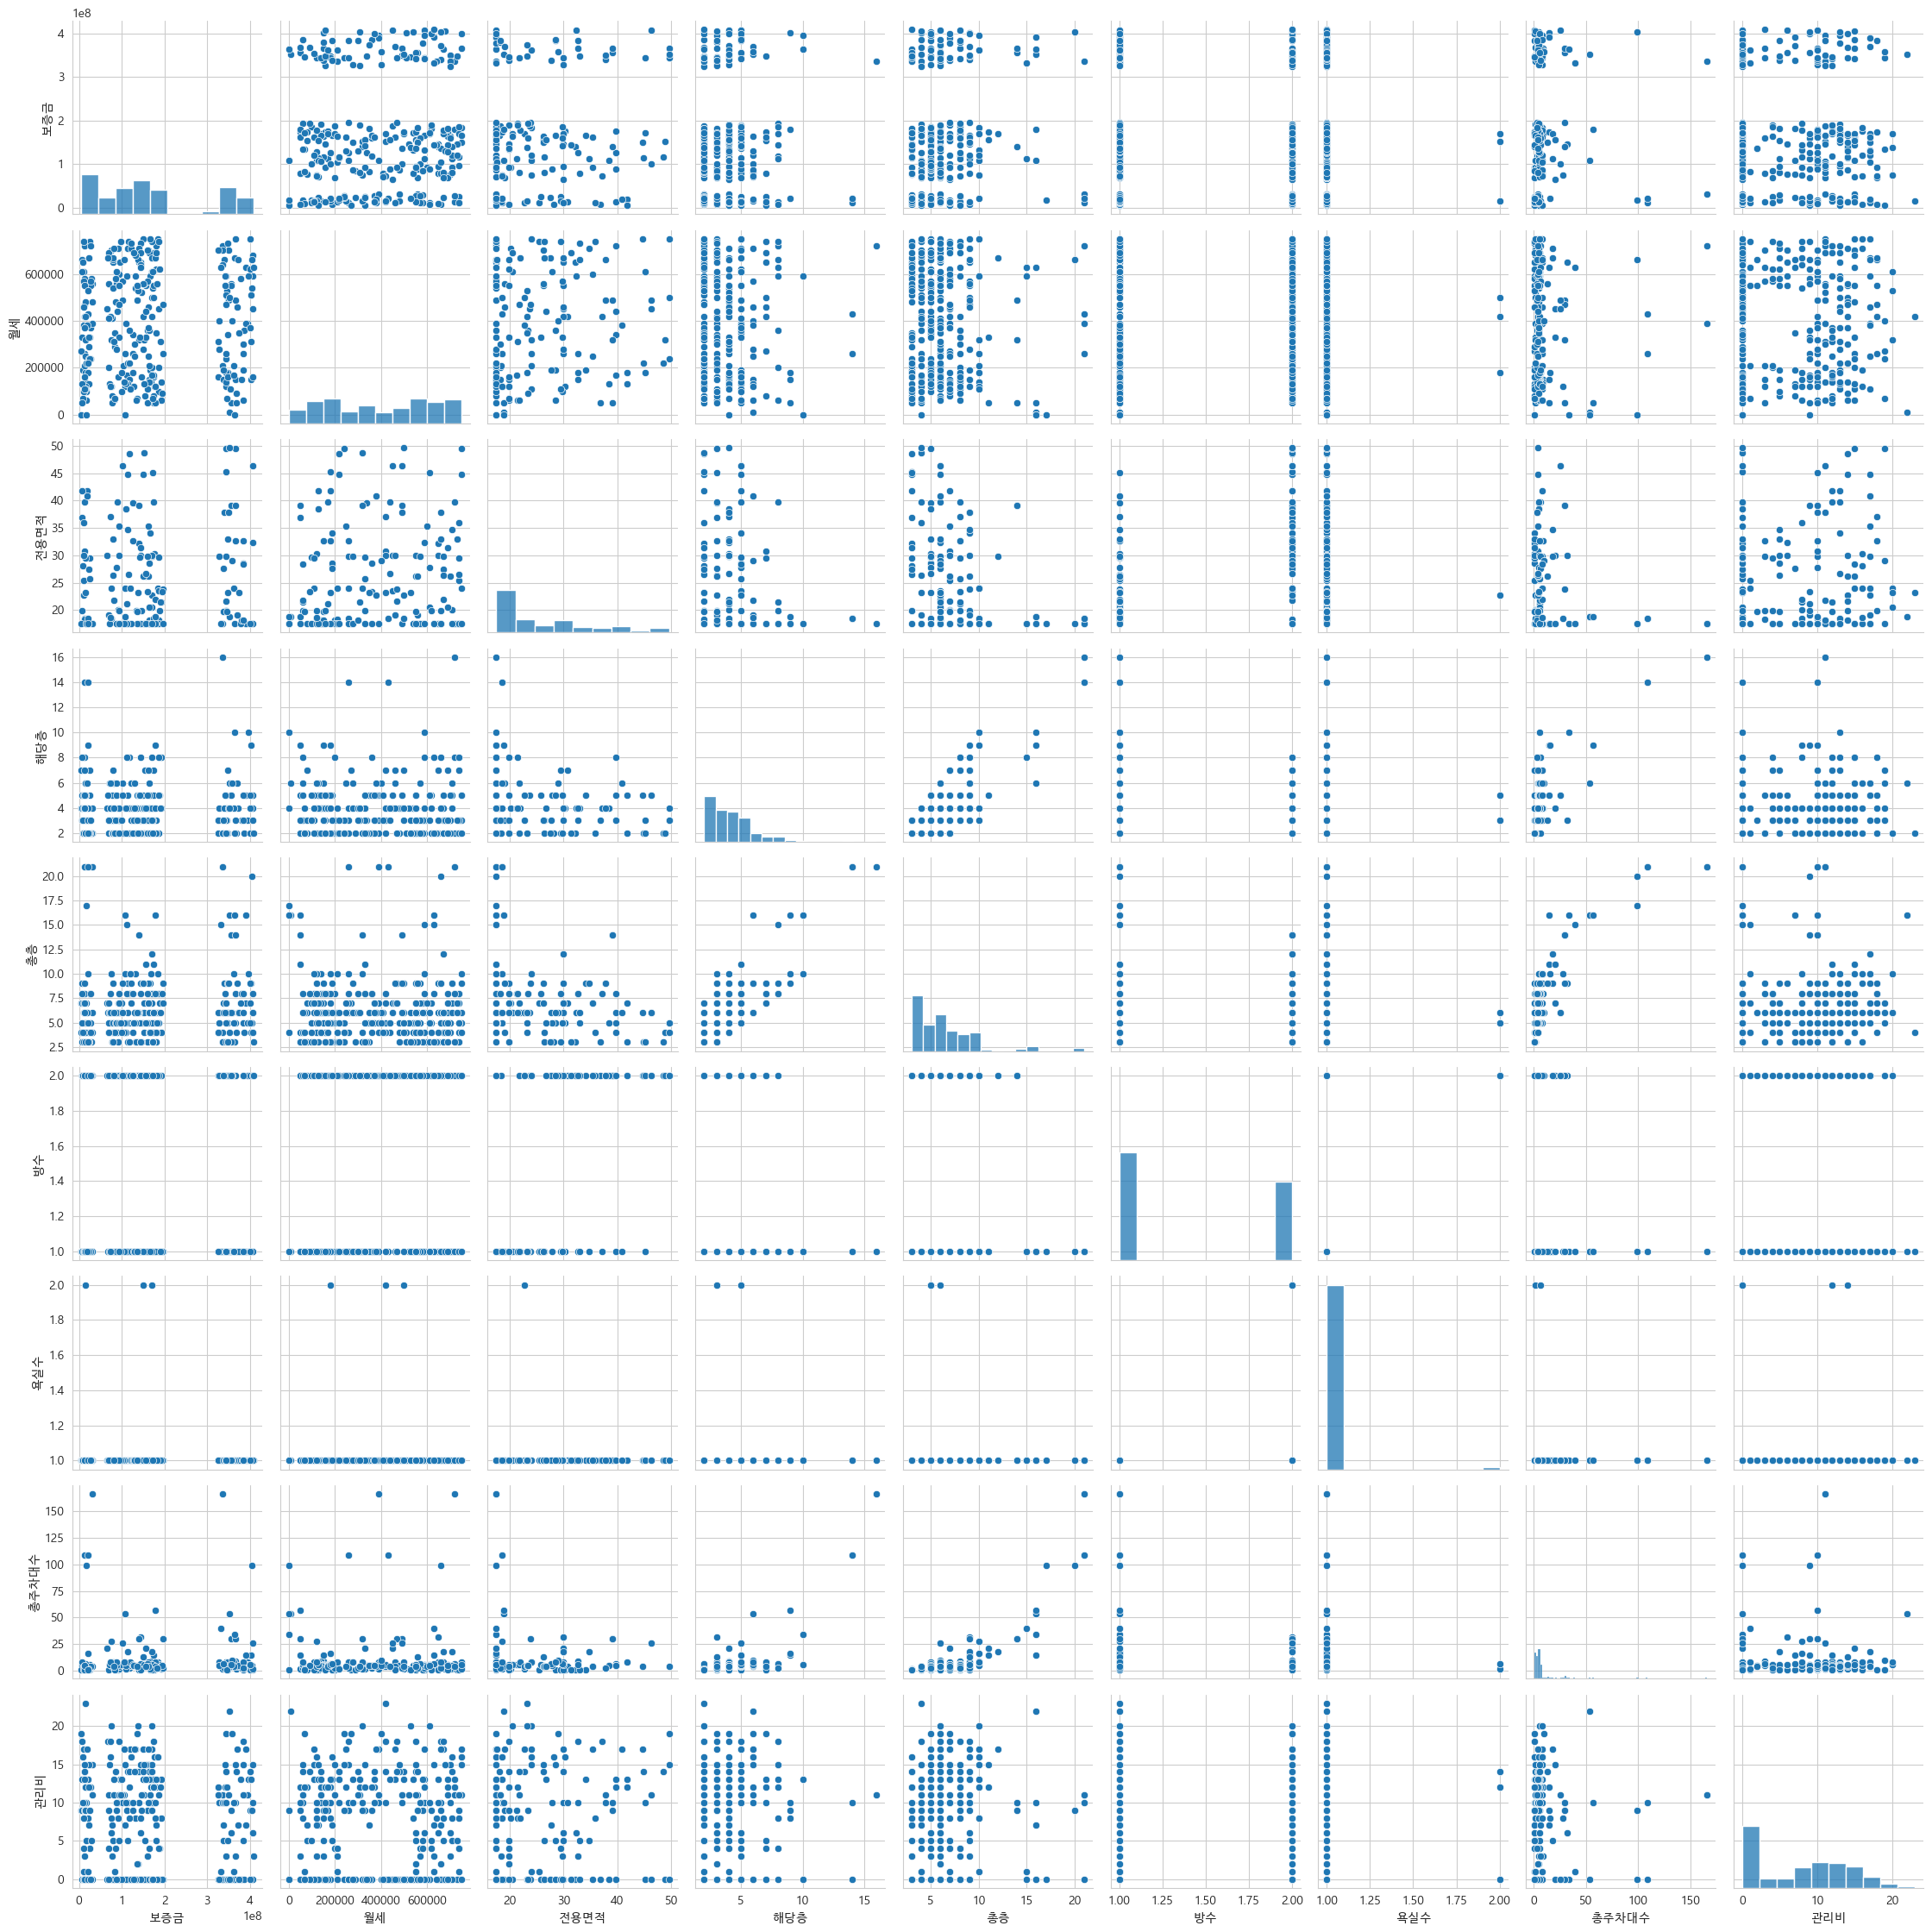

In [84]:
# Filter the train data for '허위매물여부' == 1
fraud_data = train[train['허위매물여부'] == 1]

# Select the relevant columns
columns = ['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비']

# Plot the scatter plot matrix
g = sns.pairplot(fraud_data[columns])

# 각 subplot의 레이블에 폰트 적용
for ax in g.axes.flat:
    # X축 레이블 폰트 설정
    ax.set_xlabel(ax.get_xlabel(), fontproperties=fontprop)
    # Y축 레이블 폰트 설정
    ax.set_ylabel(ax.get_ylabel(), fontproperties=fontprop)

plt.tight_layout()
plt.show()
# '보증금', '월세' shows little impact on the fraud rate. Later, use PCA to check the impact of these columns
# '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비' shows that the fraud rate is higher when the value is lower

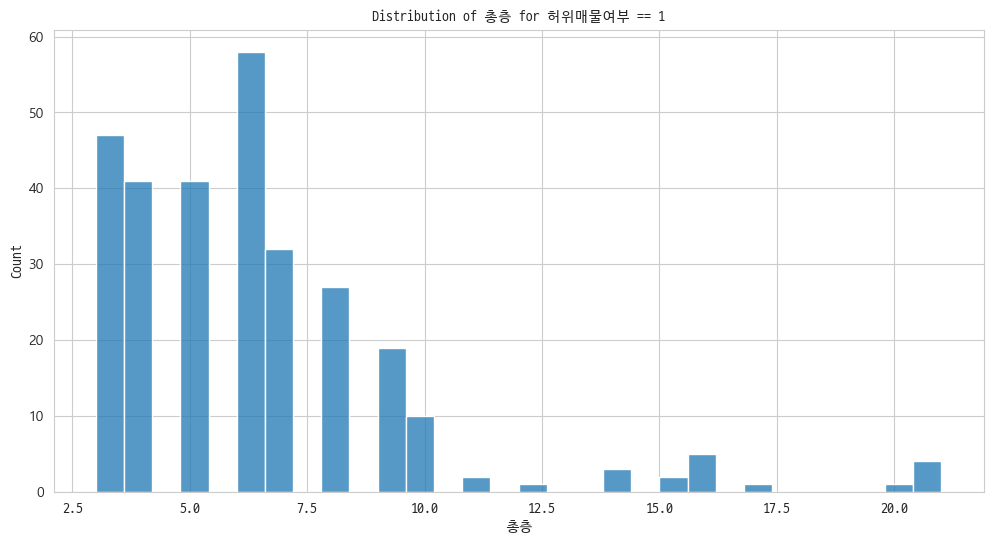

In [85]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부']== 1], x='총층', bins=30)
plt.title('Distribution of 총층 for 허위매물여부 == 1', fontproperties=fontprop)
plt.xlabel('총층', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

#### Visualize 월세 and 보증금

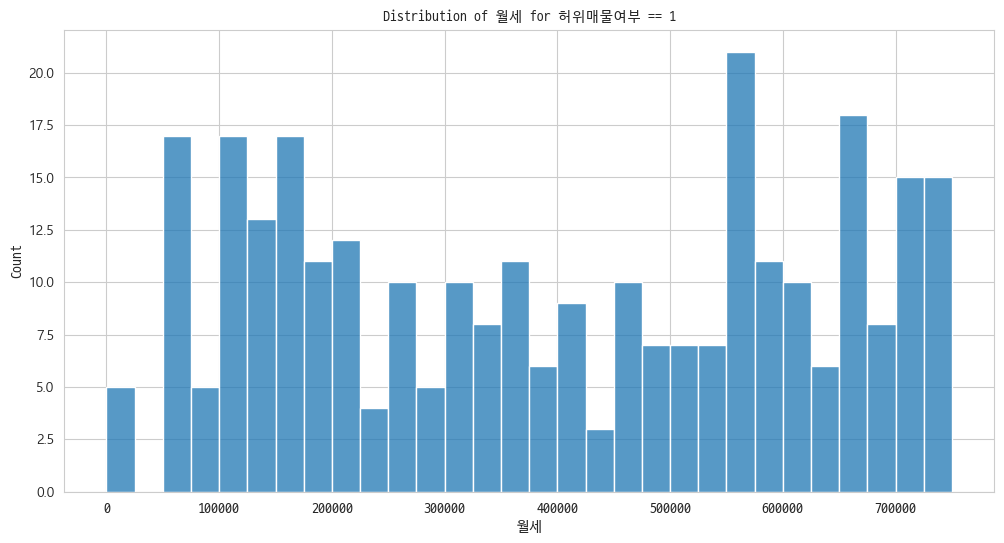

In [86]:
# Check correlation '월세' and '허위매물여부'== 1
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 1], x='월세', bins=30)
plt.title('Distribution of 월세 for 허위매물여부 == 1', fontproperties=fontprop)
plt.xlabel('월세', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

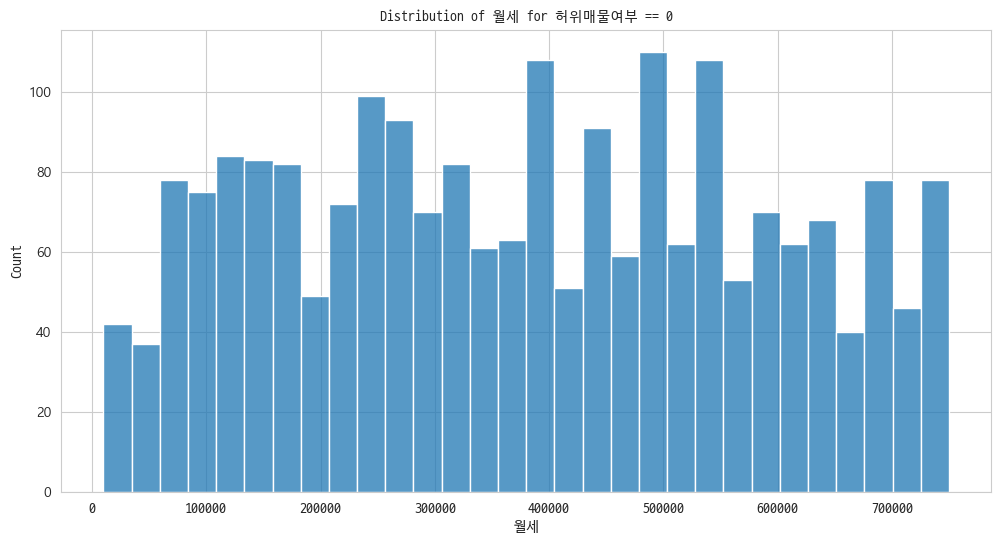

In [87]:
# Check correlation '월세' and '허위매물여부'== 0
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 0], x='월세', bins=30)
plt.title('Distribution of 월세 for 허위매물여부 == 0', fontproperties=fontprop)
plt.xlabel('월세', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

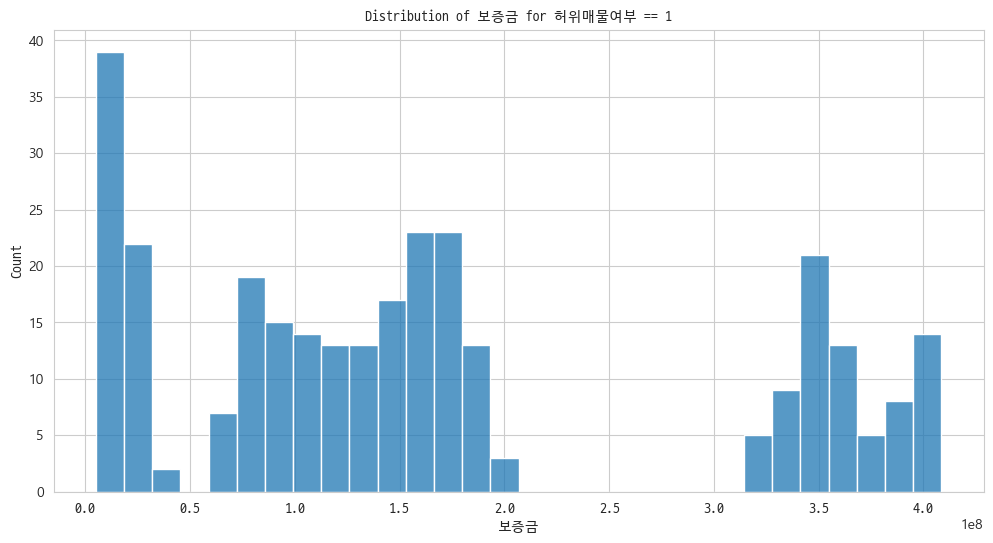

In [88]:
# Check correlation '보증금' and '허위매물여부'== 1
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 1], x='보증금', bins=30)
plt.title('Distribution of 보증금 for 허위매물여부 == 1', fontproperties=fontprop)
plt.xlabel('보증금', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

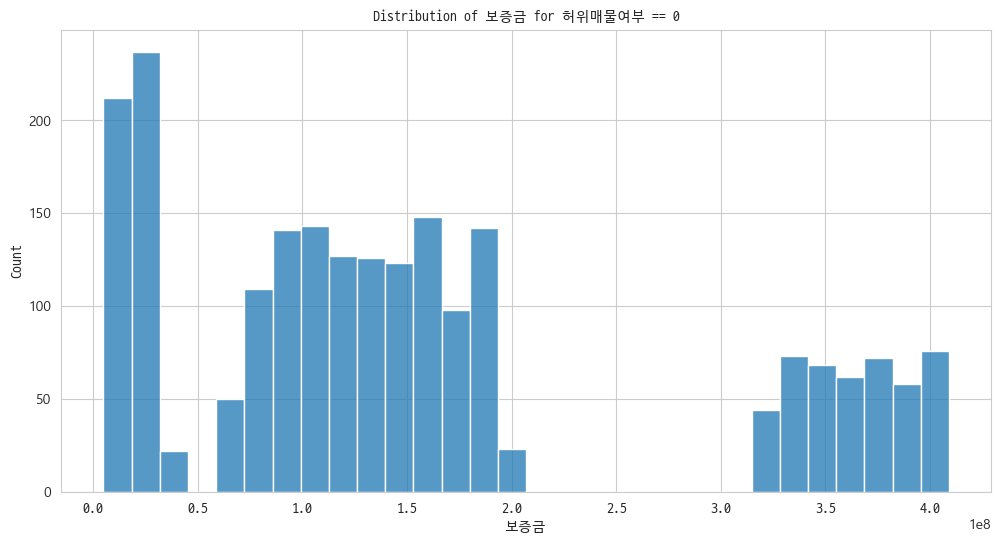

In [89]:
# Check correlation '보증금' and '허위매물여부'== 0
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 0], x='보증금', bins=30)
plt.title('Distribution of 보증금 for 허위매물여부 == 0', fontproperties=fontprop)
plt.xlabel('보증금', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

## Dealing with NA

Note that '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수' have NAs. They seems negatively correlated to the '허위매물여부'.

In [258]:
# Count the number of rows with NA values in the train DataFrame
na_rows_train = train.isna().any(axis=1).sum()
print(f"Number of rows with NA values in the train DataFrame: {na_rows_train}")

# Count the number of rows with NA values in the test DataFrame
na_rows_test = test.isna().any(axis=1).sum()
print(f"Number of rows with NA values in the test DataFrame: {na_rows_test}")

Number of rows with NA values in the train DataFrame: 1178
Number of rows with NA values in the test DataFrame: 291


In [259]:
# Count the number of NA rows for each 0 and 1 in the '허위매물여부' column
na_counts_by_label = train.groupby('허위매물여부').apply(lambda x: x.isna().sum(axis=1).gt(0).sum())
print(na_counts_by_label)

허위매물여부
0    963
1    215
dtype: int64


C:\Users\김종우\AppData\Local\Temp\ipykernel_110596\1077500665.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  na_counts_by_label = train.groupby('허위매물여부').apply(lambda x: x.isna().sum(axis=1).gt(0).sum())


In [260]:
train['허위매물여부'].value_counts()
# The number of NA rows is too many for '허위매물여부' == 1
# So we can't drop the NA rows for '허위매물여부' == 1
# But maybe we can drop the NA rows for '허위매물여부' == 0

허위매물여부
0    2154
1     298
Name: count, dtype: int64

In [261]:
major_missing_rate = na_counts_by_label[0] / train['허위매물여부'].value_counts()[0]
minor_missing_rate = na_counts_by_label[1] / train['허위매물여부'].value_counts()[1]
print(f"Majority class missing rate: {major_missing_rate:.2f}")
print(f"Minority class missing rate: {minor_missing_rate:.2f}")
# Minor class missing rate is too high to drop the NA rows
# Containing Missing value might be indicator of the fraud 

Majority class missing rate: 0.45
Minority class missing rate: 0.72


In [262]:
# # Set the label column representing the NA values in the train data
# train['NA_label'] = train.isna().any(axis=1).astype(int)
# train['NA_label'].value_counts()
# # Later, use this column to delete the rows with NA values in '허위매물여부' == 0.

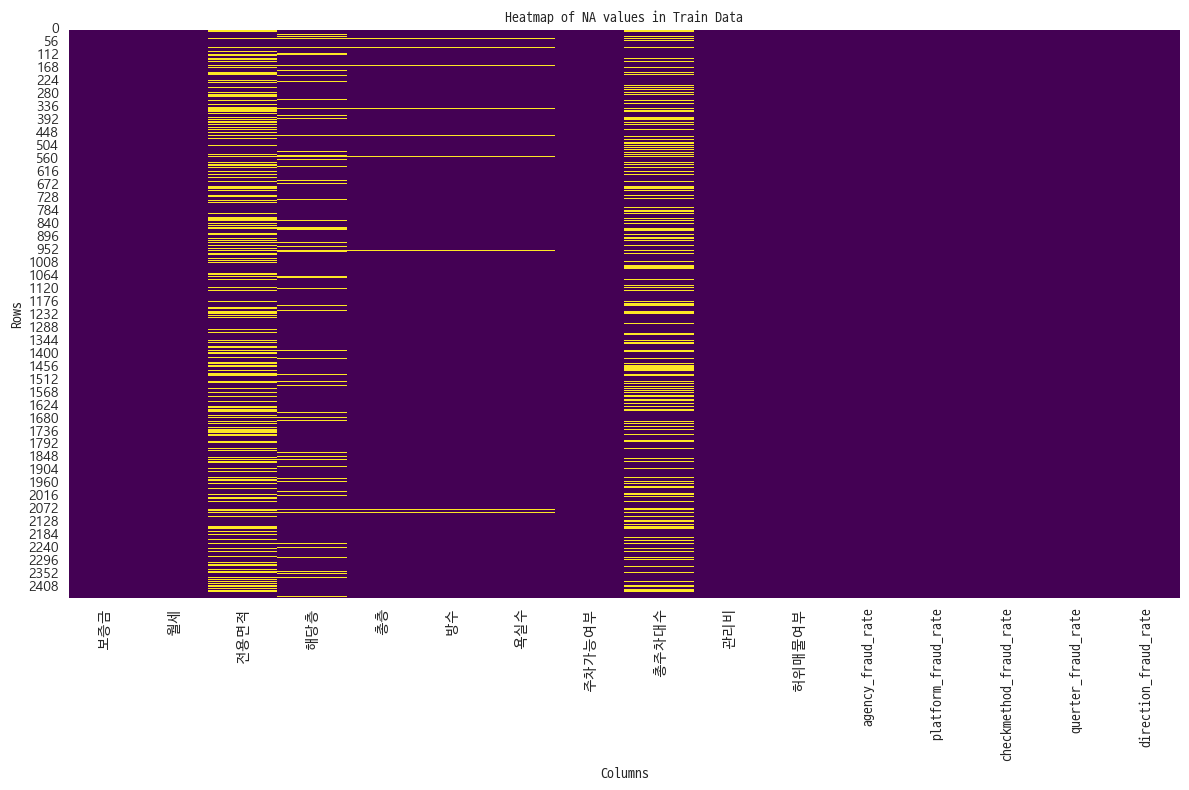

In [263]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of NA values in Train Data', fontproperties=fontprop)
plt.xlabel('Columns', fontproperties=fontprop)
plt.xticks(rotation=90, fontproperties=fontprop)
plt.ylabel('Rows', fontproperties=fontprop)
plt.tight_layout()
plt.show()
# Why there are so many NA values in the '전용면적' column?

In [264]:
train_major = train[train['허위매물여부'] == 0]; train_minor = train[train['허위매물여부'] == 1]
print(train_major.shape, train_minor.shape)

(2154, 16) (298, 16)


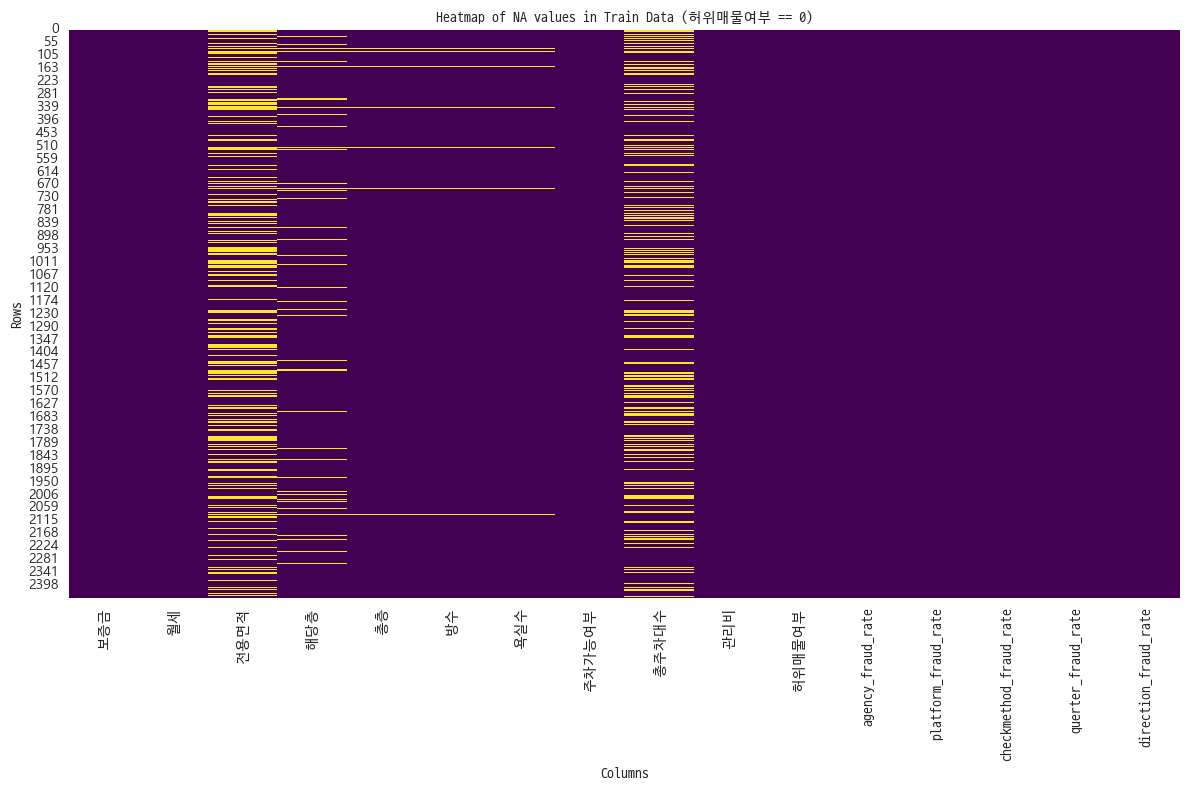

In [265]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_major.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of NA values in Train Data (허위매물여부 == 0)', fontproperties=fontprop)
plt.xlabel('Columns', fontproperties=fontprop)
plt.xticks(rotation=90, fontproperties=fontprop)
plt.ylabel('Rows', fontproperties=fontprop)
plt.tight_layout()
plt.show()

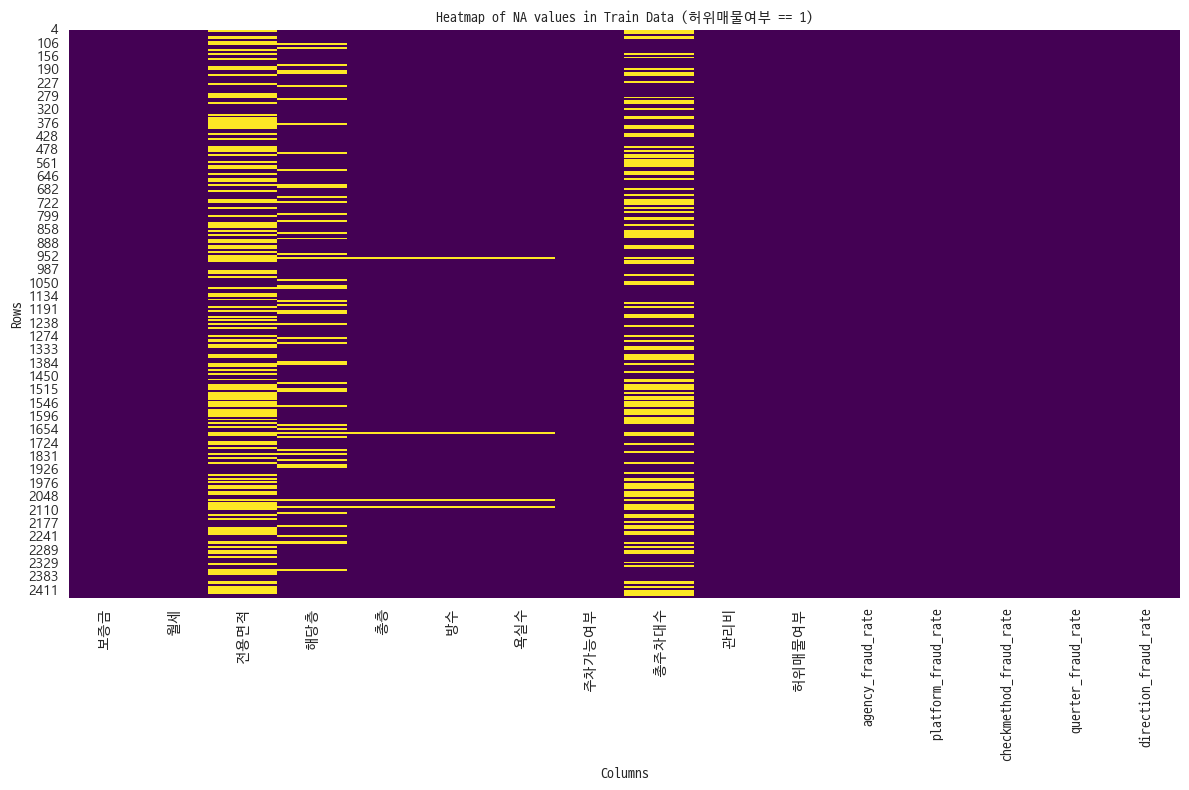

In [266]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_minor.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of NA values in Train Data (허위매물여부 == 1)', fontproperties=fontprop)
plt.xlabel('Columns', fontproperties=fontprop)
plt.xticks(rotation=90, fontproperties=fontprop)
plt.ylabel('Rows', fontproperties=fontprop)
plt.tight_layout()
plt.show()

In [267]:
# NA rate of each NA-containing columns for the both major and minor class
print(train_major['전용면적'].isna().sum() / len(train_major), train_minor['전용면적'].isna().sum() / len(train_minor))
print(train_major['해당층'].isna().sum() / len(train_major), train_minor['해당층'].isna().sum() / len(train_minor))
print(train_major['총층'].isna().sum() / len(train_major), train_minor['총층'].isna().sum() / len(train_minor))
print(train_major['방수'].isna().sum() / len(train_major), train_minor['방수'].isna().sum() / len(train_minor))
print(train_major['욕실수'].isna().sum() / len(train_major), train_minor['욕실수'].isna().sum() / len(train_minor))
print(train_major['총주차대수'].isna().sum() / len(train_major), train_minor['총주차대수'].isna().sum() / len(train_minor))
# NA rates of '총층', '방수', '욕실수' are similar for both major and minor class
# NA rates of '전용면적', '해당층', '총주차대수' are clearly higher for the minor class

0.3008356545961003 0.4664429530201342
0.08170844939647168 0.17785234899328858
0.005571030640668524 0.013422818791946308
0.005571030640668524 0.013422818791946308
0.0064995357474466105 0.013422818791946308
0.26648096564531104 0.40939597315436244


In [268]:
diff_na_rate_area = train_minor['전용면적'].isna().sum() / len(train_minor) - train_major['전용면적'].isna().sum() / len(train_major)
diff_na_rate_floor = train_minor['해당층'].isna().sum() / len(train_minor) - train_major['해당층'].isna().sum() / len(train_major)
diff_na_rate_total_floor = train_minor['총층'].isna().sum() / len(train_minor) - train_major['총층'].isna().sum() / len(train_major)
diff_na_rate_rooms = train_minor['방수'].isna().sum() / len(train_minor) - train_major['방수'].isna().sum() / len(train_major)
diff_na_rate_bathrooms = train_minor['욕실수'].isna().sum() / len(train_minor) - train_major['욕실수'].isna().sum() / len(train_major)
diff_na_rate_parking = train_minor['총주차대수'].isna().sum() / len(train_minor) - train_major['총주차대수'].isna().sum() / len(train_major)

print(f"Difference in NA rate for 전용면적: {diff_na_rate_area:.2f}")
print(f"Difference in NA rate for 해당층: {diff_na_rate_floor:.2f}")
print(f"Difference in NA rate for 총층: {diff_na_rate_total_floor:.2f}")
print(f"Difference in NA rate for 방수: {diff_na_rate_rooms:.2f}")
print(f"Difference in NA rate for 욕실수: {diff_na_rate_bathrooms:.2f}")
print(f"Difference in NA rate for 총주차대수: {diff_na_rate_parking:.2f}")

Difference in NA rate for 전용면적: 0.17
Difference in NA rate for 해당층: 0.10
Difference in NA rate for 총층: 0.01
Difference in NA rate for 방수: 0.01
Difference in NA rate for 욕실수: 0.01
Difference in NA rate for 총주차대수: 0.14


#### Compare 3 imputers

In [269]:
# 1. Iterative Imputation (MICE - Multiple Imputation by Chained Equations)
# Using RandomForest as the estimator for better handling of potential non-linear relationships
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    random_state=42,
    max_iter=10
)

# 2. KNN Imputation with feature-specific distance metrics
imputer = KNNImputer(n_neighbors=5, weights='distance')

# 3. Advanced Iterative Imputation with fraud-aware weighting
class FraudAwareImputer:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.column_means = {}
        self.column_fraud_means = {}
        
    def fit(self, X, fraud_labels):
        for column in X.columns:
            # Calculate means for fraud and non-fraud cases
            self.column_means[column] = X[column].mean()
            self.column_fraud_means[column] = {
                0: X[fraud_labels == 0][column].mean(),
                1: X[fraud_labels == 1][column].mean()
            }
        return self
    
    def transform(self, X, fraud_probabilities):
        X_imputed = X.copy()
        
        for column in X.columns:
            mask = X_imputed[column].isna()
            if mask.any():
                # Weight the imputation based on fraud probability
                imputed_values = (
                    fraud_probabilities[mask] * self.column_fraud_means[column][1] +
                    (1 - fraud_probabilities[mask]) * self.column_fraud_means[column][0]
                )
                X_imputed.loc[mask, column] = imputed_values
                
        return X_imputed

In [270]:
def compare_imputation_methods(df, target='허위매물여부'):
   na_columns = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']
   X = df[na_columns].copy()
   y = df[target]
   
   # Create validation mask for non-NaN values
   orig_data = X.copy()
   validation_mask = ~X.isna()
   
   # Create artificial NaNs
   # These will be used to calculate MSE only for these values
   np.random.seed(42)
   artificial_mask = np.random.rand(*X.shape) < 0.2
   X[artificial_mask & validation_mask] = np.nan
   
   results = {}
   imputers = {
        'iterative': IterativeImputer(random_state=42),
        'knn': KNNImputer(n_neighbors=5, weights='distance'),
        'fraud_aware': FraudAwareImputer(n_neighbors=5)
   }
   
   for name, imputer in imputers.items():
       if name == 'fraud_aware':
           imputed = imputer.fit(X, y).transform(X, y)
       else:
           imputed = pd.DataFrame(
               imputer.fit_transform(X),
               columns=X.columns,
               index=X.index
           )
       
       # Calculate MSE only for artificially created NaNs
       mse = float(((orig_data[artificial_mask & validation_mask] - 
               imputed[artificial_mask & validation_mask])**2).mean().mean())
       results[name] = mse
   
   return results

In [271]:
# Compare methods
results = compare_imputation_methods(train)
for method, error in results.items():
    print(f"{method}: {error:.4f} MSE")

c:\ProgramData\miniconda3\envs\dacon_realestate\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


iterative: 125.1504 MSE
knn: 147.9587 MSE
fraud_aware: 131.8947 MSE


In [272]:
# Since the 'iterative' method shows the best performance, we will use it for imputation
# Using RandomForest as the estimator for better handling of potential non-linear relationships
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    random_state=42,
    max_iter=10
)

# Impute the missing values in the train and test data
na_columns = ['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']
train_na_X = train[na_columns].copy()
test_na_X = test[na_columns].copy()

train_imputed = pd.DataFrame(
               imputer.fit_transform(train_na_X),
               columns=train_na_X.columns,
               index=train_na_X.index
           )
test_imputed = pd.DataFrame(
               imputer.fit_transform(test_na_X),
               columns=test_na_X.columns,
               index=test_na_X.index
           )

c:\ProgramData\miniconda3\envs\dacon_realestate\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\ProgramData\miniconda3\envs\dacon_realestate\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [273]:
train[na_columns] = train_imputed[na_columns]
test[na_columns] = test_imputed[na_columns]

In [274]:
# Check the NA values in the train and test data
print(train.isna().sum(), test.isna().sum())

보증금                       0
월세                        0
전용면적                      0
해당층                       0
총층                        0
방수                        0
욕실수                       0
주차가능여부                    0
총주차대수                     0
관리비                       0
허위매물여부                    0
agency_fraud_rate         0
platform_fraud_rate       0
checkmethod_fraud_rate    0
querter_fraud_rate        0
direction_fraud_rate      0
dtype: int64 보증금                       0
월세                        0
전용면적                      0
해당층                       0
총층                        0
방수                        0
욕실수                       0
주차가능여부                    0
총주차대수                     0
관리비                       0
agency_fraud_rate         0
platform_fraud_rate       0
checkmethod_fraud_rate    0
querter_fraud_rate        0
direction_fraud_rate      0
dtype: int64


### Delete NAs with '허위매물여부' == 0

해봤는데 안 좋음. 오버피팅!!!

#### Visualize 월세 and 보증금

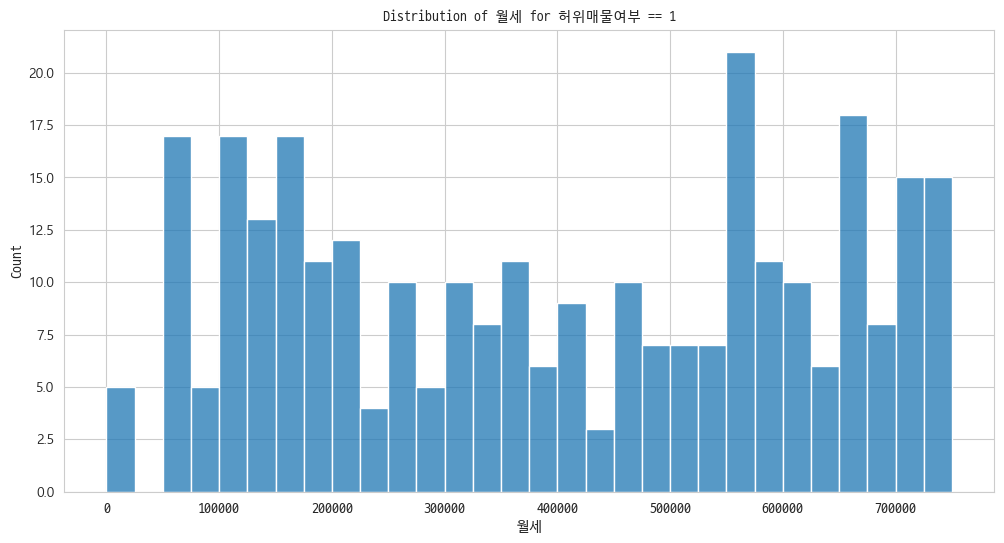

In [275]:
# Check correlation '월세' and '허위매물여부'== 1
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 1], x='월세', bins=30)
plt.title('Distribution of 월세 for 허위매물여부 == 1', fontproperties=fontprop)
plt.xlabel('월세', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

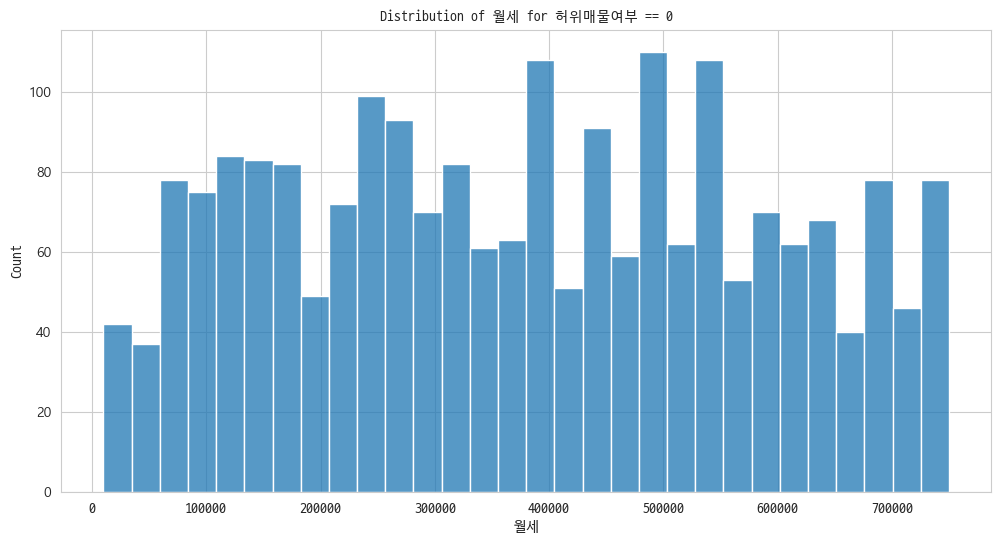

In [276]:
# Check correlation '월세' and '허위매물여부'== 0
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 0], x='월세', bins=30)
plt.title('Distribution of 월세 for 허위매물여부 == 0', fontproperties=fontprop)
plt.xlabel('월세', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

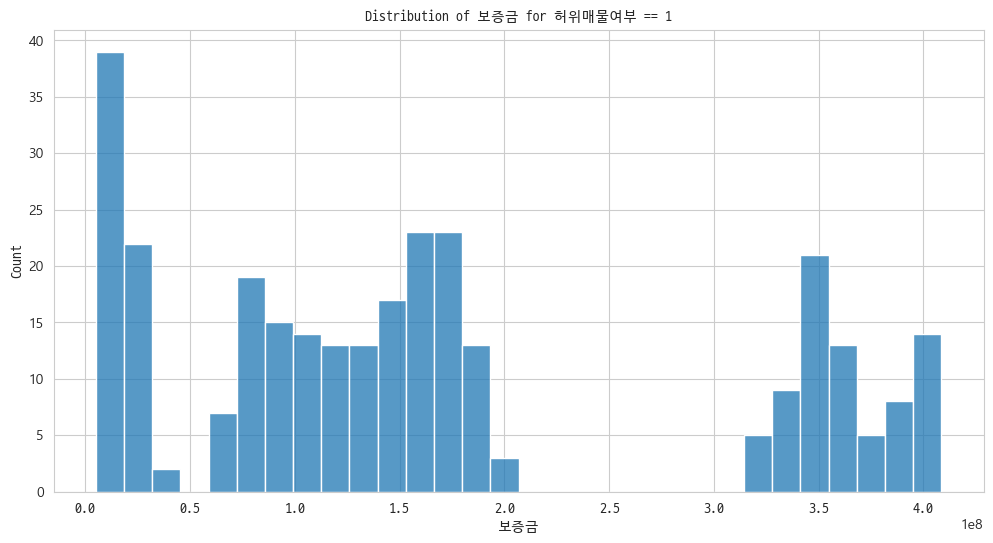

In [277]:
# Check correlation '보증금' and '허위매물여부'== 1
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 1], x='보증금', bins=30)
plt.title('Distribution of 보증금 for 허위매물여부 == 1', fontproperties=fontprop)
plt.xlabel('보증금', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

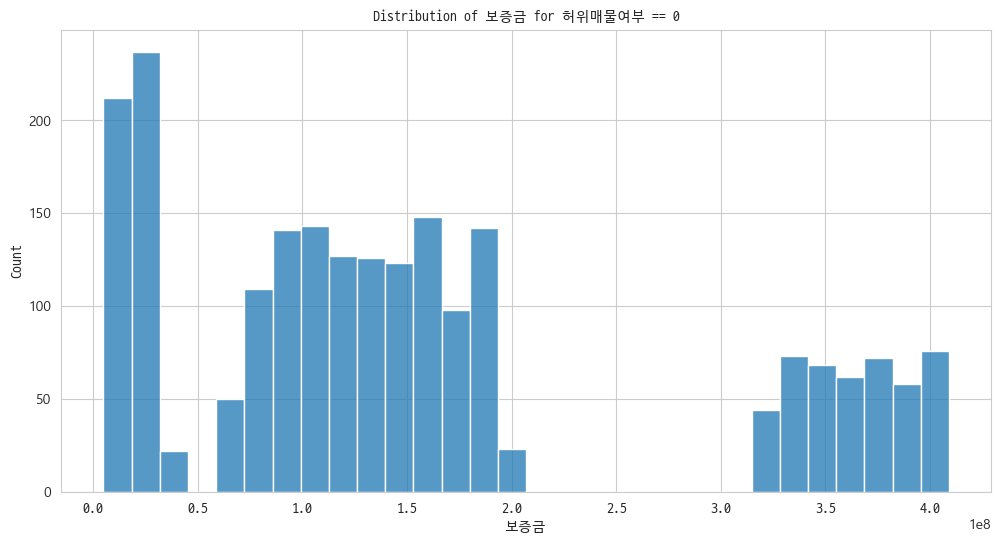

In [278]:
# Check correlation '보증금' and '허위매물여부'== 0
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 0], x='보증금', bins=30)
plt.title('Distribution of 보증금 for 허위매물여부 == 0', fontproperties=fontprop)
plt.xlabel('보증금', fontproperties=fontprop)
plt.ylabel('Count', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.show()

### '관리비' column

Given that '관리비' column shows its meaningfulness in LASSO, apply further modifications
But it seems numeric distribution solves everyting.

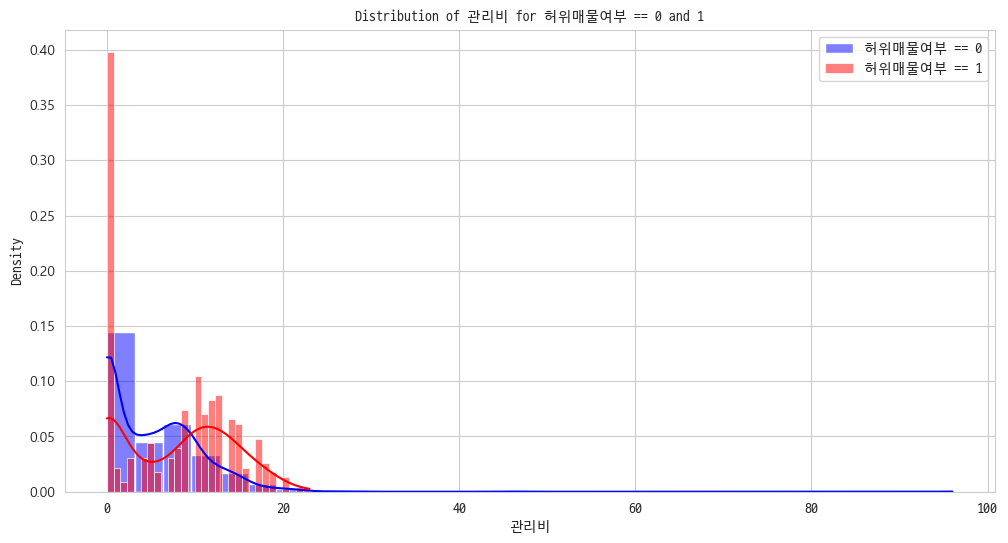

In [279]:
# Plotting '관리비' and '허위매물여부' of both 0 and 1. Normalize the y-axis
plt.figure(figsize=(12, 6))
sns.histplot(data=train[train['허위매물여부'] == 0], x='관리비', bins=30, kde=True, stat='density', color='blue', label='허위매물여부 == 0')
sns.histplot(data=train[train['허위매물여부'] == 1], x='관리비', bins=30, kde=True, stat='density', color='red', label='허위매물여부 == 1')
plt.title('Distribution of 관리비 for 허위매물여부 == 0 and 1', fontproperties=fontprop)
plt.xlabel('관리비', fontproperties=fontprop)
plt.ylabel('Density', fontproperties=fontprop)
plt.xticks(rotation=0, fontproperties=fontprop)
plt.legend(prop=fontprop)
plt.show()

## Check Feature Importance with Undersampling

In [280]:
# Calculate the value counts of the '허위매물여부' column
value_counts = train['허위매물여부'].value_counts()

# Calculate the imbalanced rate
imbalanced_rate = value_counts[1] / (value_counts[0] + value_counts[1])
print(f"Imbalanced rate: {imbalanced_rate:.2f}")

Imbalanced rate: 0.12


In [281]:
# Apply Random undersampling to the training data wiht the '허위매물여부' == 0
# Define the undersampler
desired_ratio = 1 # Desired ratio of the minority class to the majority class
rus = RandomUnderSampler(sampling_strategy=desired_ratio, random_state=42)

In [282]:
X = train.drop('허위매물여부', axis=1)
y = train['허위매물여부']

# Apply undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Convert back to DataFrame for consistency
train_resampled = pd.DataFrame(X_resampled, columns=X.columns)
train_resampled['허위매물여부'] = y_resampled

# Check the distribution of the target variable
print(train_resampled['허위매물여부'].value_counts())

허위매물여부
0    298
1    298
Name: count, dtype: int64


### LASSO

Tried alpha = 0.03, 0.05, 0.07.
Among them, alpha == 0.05 shows the best result.

LASSO Coefficients:
보증금                       0.000000
월세                        0.000000
전용면적                      0.000000
해당층                      -0.000000
총층                       -0.007077
방수                        0.000000
욕실수                      -0.000000
주차가능여부                   -0.011981
총주차대수                    -0.002796
관리비                       0.016372
agency_fraud_rate         0.152676
platform_fraud_rate       0.000000
checkmethod_fraud_rate    0.000000
querter_fraud_rate        0.198021
direction_fraud_rate      0.015655
dtype: float64


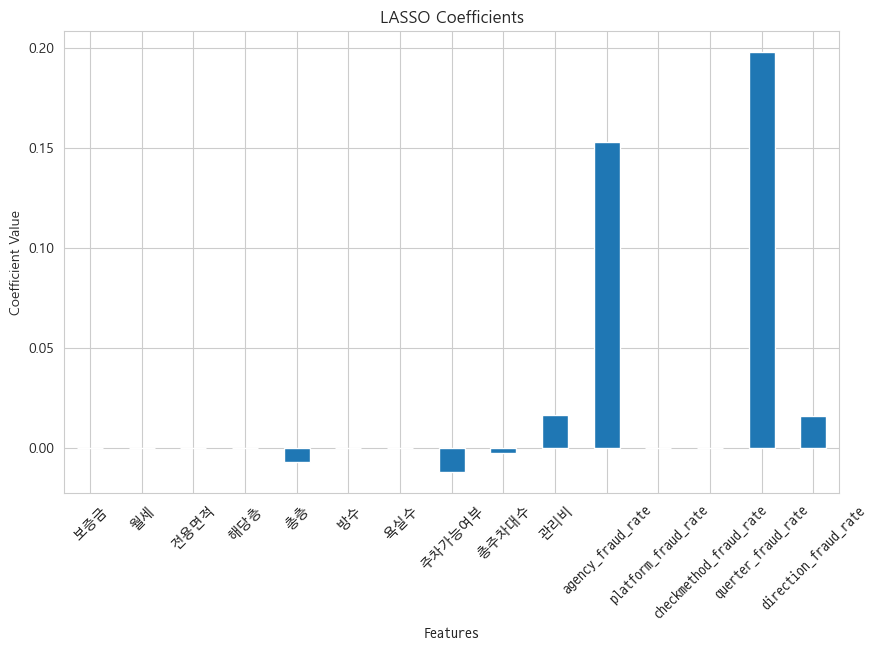

In [283]:
# Separate features and target variable
X = train_resampled.drop('허위매물여부', axis=1)
y = train_resampled['허위매물여부']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply LASSO regression
lasso = Lasso(alpha=0.04)  # You can adjust the alpha value
lasso.fit(X_scaled, y)

# Get the coefficients
lasso_coefficients = pd.Series(lasso.coef_, index=X.columns)

# Print the coefficients
print("LASSO Coefficients:")
print(lasso_coefficients)

# Plot the coefficients
plt.figure(figsize=(10, 6))
lasso_coefficients.plot(kind='bar')
plt.title('LASSO Coefficients')
plt.xlabel('Features', fontproperties=fontprop)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.ylabel('Coefficient Value')
plt.show()

In [284]:
# Check the correlation of '주차가능여부' and '허위매물여부'==1
train[train['허위매물여부'] == 1].groupby('주차가능여부').size()
# This shows that '주차가능여부' == 0 has higher fraud rate

주차가능여부
0    198
1    100
dtype: int64

#### LASSO: dropping zero coef-Cols.

In [285]:
# Drop variables with zero coefficients from the LASSO regression
zero_coefficients = lasso_coefficients[lasso_coefficients == 0].index
train_lasso = train.drop(zero_coefficients, axis=1)
test_lasso = test.drop(zero_coefficients, axis=1)

# Additional dropping
train_lasso = train_lasso.drop(['총층', '총주차대수'], axis=1)
test_lasso = test_lasso.drop(['총층', '총주차대수'], axis=1)

# Check the survived columns
print(test_lasso.columns)

Index(['주차가능여부', '관리비', 'agency_fraud_rate', 'querter_fraud_rate',
       'direction_fraud_rate'],
      dtype='object')


### Ridge

c:\ProgramData\miniconda3\envs\dacon_realestate\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.03703e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


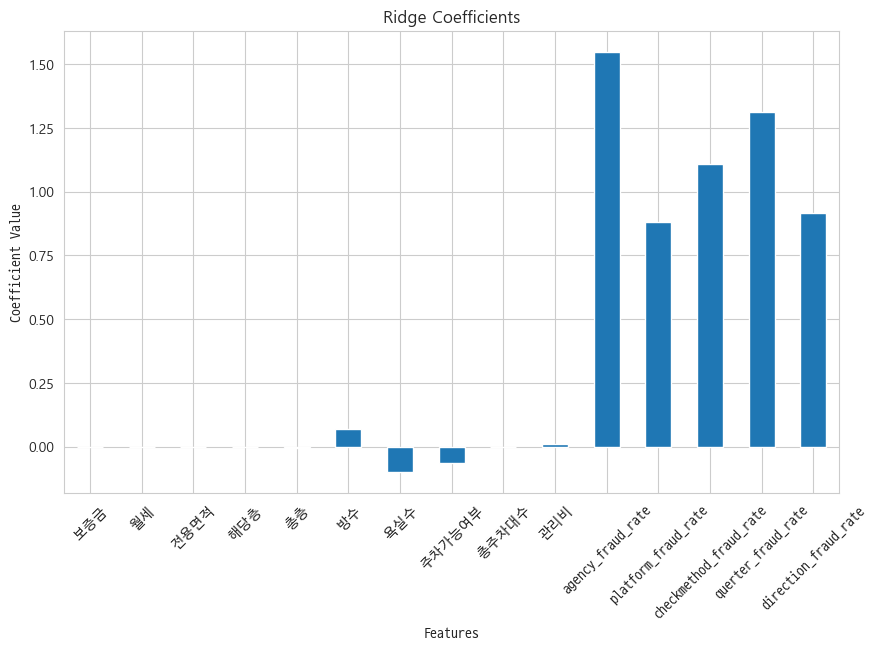

In [286]:
from sklearn.linear_model import Ridge

# Initialize the Ridge regression model
ridge = Ridge(alpha=0.06)  # You can adjust the alpha value

# Fit the model
ridge.fit(X, y)

# Get the coefficients
ridge_coefficients = pd.Series(ridge.coef_, index=X.columns)

# Print the coefficients
# print("Ridge Coefficients:")
# print(ridge_coefficients)

# Plot the coefficients
plt.figure(figsize=(10, 6))
ridge_coefficients.plot(kind='bar')
plt.title('Ridge Coefficients')
plt.xlabel('Features', fontproperties=fontprop)
plt.xticks(rotation=45, fontproperties=fontprop)
plt.ylabel('Coefficient Value', fontproperties=fontprop)
plt.show()

In [121]:
# Drop the variables with near-zero coefficients from the Ridge regression
near_zero_coefficients = ridge_coefficients[ridge_coefficients < 0.00005].index
train_ridge = train.drop(near_zero_coefficients, axis=1)
test_ridge = test.drop(near_zero_coefficients, axis=1)

# Check the columns that are survived
print(test_ridge.columns)

Index(['방수', '관리비', 'agency_fraud_rate', 'platform_fraud_rate',
       'checkmethod_fraud_rate', 'querter_fraud_rate', 'direction_fraud_rate'],
      dtype='object')


### Dimension Reduction

In [287]:
#  Select Ridge
# train = train_ridge.copy()
# test = test_ridge.copy()

# Select LASSO
train = train_lasso.copy()
test = test_lasso.copy()

# Select specific columns
# selected_columns = ['주차가능여부', '관리비', 'querter_fraud_rate', 'agency_fraud_rate'] # Given by LASSO
# train = train[selected_columns + ['허위매물여부']].copy()
# test = test[selected_columns].copy()

## Save and load data

In [288]:
# Save train and test data into csv files
train.to_csv('data/train_under_processing.csv', index=False); test.to_csv('data/test_under_processing.csv', index=False)

In [289]:
# Load the processed train and test data
train = pd.read_csv('data/train_under_processing.csv'); test = pd.read_csv('data/test_under_processing.csv')

# Sampling

## Undersampling

In [200]:
# from imblearn.under_sampling import RandomUnderSampler

# # Separate features and target variable
# X = train.drop('허위매물여부', axis=1)
# y = train['허위매물여부']

# sampling_strategy = 0.2  # Desired ratio of the minority class to the majority class
# # Define the undersampler
# rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# # Apply undersampling
# X_resampled, y_resampled = rus.fit_resample(X, y)

# # Convert back to DataFrame for consistency
# train_resampled = pd.DataFrame(X_resampled, columns=X.columns)
# train_resampled['허위매물여부'] = y_resampled

# # Check the distribution of the target variable
# print(train_resampled['허위매물여부'].value_counts())

# train = train_resampled.copy()

## Oversampling

### CTGAN

In [201]:
# Import necessary libraries
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from collections import Counter

# Separate minority and majority classes
minority_class = train[train['허위매물여부'] == 1]
majority_class = train[train['허위매물여부'] == 0]

# Create and detect metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=minority_class)

# Initialize CTGANSynthesizer with metadata
synthesizer = CTGANSynthesizer(
    metadata,
    epochs=100,
    batch_size=500,
    verbose=False
)

# Fit the synthesizer on minority class data
synthesizer.fit(minority_class)

# Generate synthetic samples
# Calculate how many samples to generate (to match majority class)
n_synthetic = round((len(majority_class) - len(minority_class)) * 0.4)

synthetic_samples = synthesizer.sample(num_rows=n_synthetic)

# Combine original minority class with synthetic samples
oversampled_minority = pd.concat([minority_class, synthetic_samples], axis=0)

# Combine with majority class to create balanced dataset
balanced_train = pd.concat([majority_class, oversampled_minority], axis=0)

# Shuffle the balanced dataset
balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_train['허위매물여부'].value_counts())

c:\Users\USER\miniconda3\envs\dacon25_realestate\Lib\site-packages\sdv\single_table\base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\USER\miniconda3\envs\dacon25_realestate\Lib\site-packages\sdv\single_table\base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


허위매물여부
0    2154
1    1040
Name: count, dtype: int64


In [ ]:
# Replace the train data with the balanced data
train = balanced_train.copy()

### ADASYN

In [238]:
from imblearn.over_sampling import ADASYN

# Separate features and target variable
X = train.drop('허위매물여부', axis=1)
y = train['허위매물여부']

# Apply ADASYN to the training data
adasyn = ADASYN(sampling_strategy=.6, random_state=42, n_neighbors=5)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Convert back to DataFrame for consistency
train_resampled = pd.DataFrame(X_resampled, columns=X.columns)
train_resampled['허위매물여부'] = y_resampled

# Check the distribution of the target variable
print(train_resampled['허위매물여부'].value_counts())

허위매물여부
0    2154
1    1309
Name: count, dtype: int64


In [239]:
train = train_resampled.copy()

# Fit & Predict

## XGBoost

In [236]:
# pip install xgboost

In [290]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os
from xgboost import XGBClassifier

In [291]:
# Separate features and target variable
X = train.drop(['허위매물여부'], axis=1)
y = train['허위매물여부']

# When No imputation
# Virtual LASSO dimension reduction
# X = train[['주차가능여부', '관리비', 'agency_fraud_rate', '2month_fraud_rate']]
# y = train['허위매물여부']

# test_virtual_lasso = test[['주차가능여부', '관리비', 'agency_fraud_rate', '2month_fraud_rate']]

### Basic

In [292]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = XGBClassifier(random_state=42)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x800 with 0 Axes>

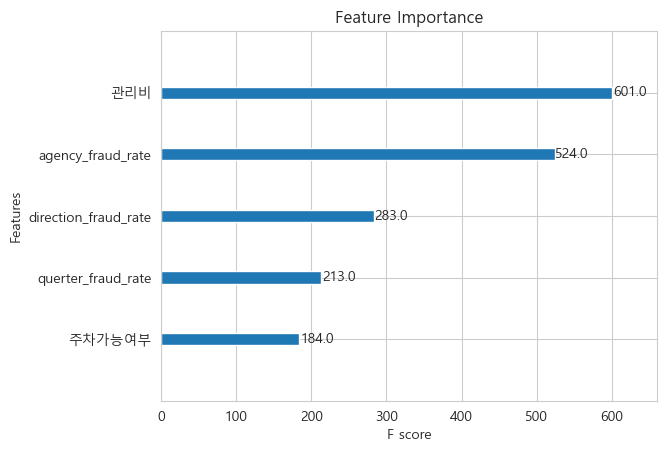

In [296]:
from xgboost import plot_importance

import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='weight')
plt.title('Feature Importance')
plt.show()

### GirdsearchCV

In [ ]:
# # Initialize the XGBClassifier
# model = XGBClassifier(
#     objective='binary:hinge',
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='aucpr' # Use AUC-PR for evaluation
#     )
# param_grid = {
#     'n_estimators':  [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
#     'max_depth': [3, 5, 7, 9, 11],
#     'learning_rate': np.linspace(0.01, 0.2, 10),
#     'scale_pos_weight': [1, 10, 25, 50, 75, 99]  # Adding scale_pos_weight to handle imbalanced data
# }
# model = GridSearchCV(estimator=model, param_grid=param_grid, 
#                            scoring='f1_macro', # roc_auc, f1_macro
#                            cv=10, verbose=0, n_jobs=-1)

# # # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Fit the model
# model.fit(X_train, y_train)
# model

c:\Users\USER\miniconda3\envs\dacon25_realestate\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='aucpr', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=N...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='binary:hinge', ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                         'max_depth': [3, 5, 7, 9, 11],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500],
                         'scale_pos_weight': [1, 10, 25, 50, 75, 99]},
             scoring='f1_macro')

In [293]:
# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9450
Precision: 0.8113
Recall: 0.7167
F1 Score: 0.7611


### Prediction

In [294]:
y_test_pred = model.predict(test)
y_test_pred = pd.DataFrame(y_test_pred, columns=['허위매물여부'])
y_test_pred.value_counts()

허위매물여부
0         557
1          56
Name: count, dtype: int64

## Catboost

In [20]:
train = train.drop('ID', axis=1); test = test.drop('ID', axis=1)

In [22]:
train.head()

,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,허위매물여부,querter_fraud_rate
0,현장확인,402500000.0,470000,NaN,NaN,15.0,서향,1.0,1.0,가능,40.0,96,t93Nt6I2I0,B플랫폼,0,0.004420
1,현장확인,170500000.0,200000,NaN,3.0,4.0,남동향,2.0,1.0,불가능,NaN,0,q39iV5J4E6,D플랫폼,0,0.004420
2,전화확인,114000000.0,380000,NaN,2.0,3.0,동향,1.0,1.0,불가능,NaN,0,b03oE4G3F6,A플랫폼,0,0.004420
3,현장확인,163500000.0,30000,36.3,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,0,0.004420
4,현장확인,346000000.0,530000,NaN,3.0,3.0,동향,2.0,1.0,불가능,NaN,0,N45gM0M7R0,B플랫폼,1,0.388889


In [24]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Import necessary libraries

# Separate features and target variable
X = train.drop(['허위매물여부'], axis=1)
y = train['허위매물여부']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

imbalance_ratio = train['허위매물여부'].value_counts()[0] / train['허위매물여부'].value_counts()[1]

# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    loss_function='Logloss',
    custom_metric=['AUC', 'F1', 'Precision', 'Recall'],
    eval_metric='F1',
    verbose=100,
    random_seed=42,
    l2_leaf_reg=3,
    border_count=254,
    bootstrap_type='Bernoulli',
    subsample=0.8,
    # auto_class_weights='Balanced',  # Let CatBoost calculate weights
    scale_pos_weight=imbalance_ratio,  # Manually set the weight
    early_stopping_rounds=50,
    use_best_model=True
)

categorical_features = ['매물확인방식', '주차가능여부', '방향', '중개사무소','제공플랫폼']
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

# Fit the model
model.fit(X_train, y_train, eval_set=(X_val, y_val),
 early_stopping_rounds=100, 
 cat_features=categorical_features_indices)

# Predict on the validation set
y_test_pred = model.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

0:	learn: 0.8440812	test: 0.7757847	best: 0.7757847 (0)	total: 203ms	remaining: 3m 23s
100:	learn: 0.9607785	test: 0.8773650	best: 0.8849630 (77)	total: 3.21s	remaining: 28.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8849630246
bestIteration = 77

Shrink model to first 78 iterations.
Accuracy: 0.8859
Precision: 0.5196
Recall: 0.8833
F1 Score: 0.6543


In [26]:
y_test_pred = pd.DataFrame(y_test_pred, columns=['허위매물여부'])
y_test_pred.value_counts()

허위매물여부
0         389
1         102
Name: count, dtype: int64

## Autogluon

Use this without NA imputation since each models has its own way to deal with NAs.

Considering no preprocessing later in light of categorical variables can be converted by various models' own methods.

In [3]:
# pip install -U ipywidgets

In [4]:
# pip install autogluon

In [5]:
import random, os

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [ ]:
import os
from autogluon.tabular import TabularPredictor

# Create directory if it doesn't exist
MODEL_PATH = 'C:/Projects/25_dacon_realastate_anomaly/autogluon_models'
os.makedirs(MODEL_PATH, exist_ok=True)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       21.19 GB / 31.89 GB (66.5%)
Disk Space Avail:   713.92 GB / 931.50 GB (76.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good acc

In [ ]:
from autogluon.tabular import TabularPredictor

# Define search spaces for each model type 
hyperparameter_search = {
    'GBM': {
        'hyperparameters': {
            'num_boost_round': [300, 325, 350, 375, 400],
            'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1, 0.2],
            'num_leaves': [16, 31, 50, 80, 120],
            'max_depth': [3, 5, 7, 9, 12, -1],  # -1 means no limit
            'min_child_weight': [1, 3, 5, 10],
            'feature_fraction': [0.5, 0.7, 0.8, 0.9, 1.0],
            'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
            'reg_alpha': [0, 0.001, 0.01, 0.1, 0.5, 1.0],
            'reg_lambda': [0, 0.1, 0.5, 1.0, 3.0, 5.0],
            'is_unbalance': [True, False],
            'scale_pos_weight': [1, 3, 5, 7, 10, 15],
            'boost_from_average': [True, False],
            'bagging_freq': [0, 1, 5],
            'min_data_in_leaf': [5, 10, 20, 50, 100]
        },
        'search_strategy': 'bayesopt',
        'search_options': {'num_trials': 20}
    },
    
    'RF': {
        'hyperparameters': {
            'n_estimators': [100, 200, 300, 500, 800],
            'max_depth': [5, 8, 12, 15, 20, None],
            'min_samples_split': [2, 5, 10, 15, 20],
            'min_samples_leaf': [1, 2, 4, 8, 16],
            'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, 0.9],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None],
            'criterion': ['gini', 'entropy', 'log_loss']
        },
        'search_strategy': 'bayesopt',
        'search_options': {'num_trials': 15}
    },
    
    'XGB': {
        'hyperparameters': {
            'n_estimators': [100, 200, 400, 600, 1000],
            'max_depth': [3, 4, 6, 8, 10, 12],
            'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
            'subsample': [0.5, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bylevel': [0.5, 0.7, 1.0],
            'min_child_weight': [1, 3, 5, 7, 10],
            'gamma': [0, 0.1, 0.2, 0.5, 1.0],
            'alpha': [0, 0.1, 0.5, 1.0, 2.0, 5.0],
            'lambda': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
            'scale_pos_weight': [1, 3, 5, 10, 15, 20],
            'tree_method': ['auto', 'exact', 'approx', 'hist'],
            'grow_policy': ['depthwise', 'lossguide']
        },
        'search_strategy': 'bayesopt',
        'search_options': {'num_trials': 20}
    },
    
    'ENS_WEIGHTED': {
        'hyperparameters': {
            'weight_initialization': ['uniform', 'proportional'],
            'use_orig_features': [True, False],
            'max_base_models': [5, 10, 15, 20, 25, 'all'],
            'min_model_weight': [0.0001, 0.001, 0.01, 0.05, 0.1],
            'soft_voting': [True, False],
            'refit_full': [True]
        }
    }
}

# Create predictor with Bayesian hyperparameter search
predictor = TabularPredictor(
    label='허위매물여부',
    eval_metric='f1_macro',
    problem_type='binary',
    path=MODEL_PATH
).fit(
    train_data=train,
    num_bag_folds=5,
    num_stack_levels=2,
    time_limit=60*60*2,
    excluded_model_types=['XT', 'KNN', 'CAT', 'NN_TORCH', 'LR', 
                         'FASTAI', 'TRANSF', 'AG_TEXT_NN', 'AG_IMAGE_NN', 
                         'AG_AUTOMM', 'FT_TRANSFORMER', 'TABPFN', 'TABPFNMIX', 
                         'FASTTEXT', 'SIMPLE_ENS_WEIGHTED', 'IM_RULEFIT', 
                         'IM_GREEDYTREE', 'IM_FIGS', 'IM_HSTREE', 
                         'IM_BOOSTEDRULES', 'VW', 'DUMMY']
)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
Memory Avail:       19.13 GB / 31.89 GB (60.0%)
Disk Space Avail:   713.58 GB / 931.50 GB (76.6%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference speed.
	presets='good'         : Good acc

In [27]:
# 1. Get the leaderboard to see which model performed best
leaderboard = predictor.leaderboard(extra_info=True)
print(leaderboard)

                      model  score_val eval_metric  pred_time_val   fit_time  \
0         LightGBMXT_BAG_L3   0.934001    f1_macro       0.613749  25.419008   
1       WeightedEnsemble_L4   0.934001    f1_macro       0.615749  25.647101   
2      LightGBMLarge_BAG_L2   0.933801    f1_macro       0.328145  15.231913   
3       WeightedEnsemble_L3   0.933801    f1_macro       0.330148  15.407959   
4         LightGBMXT_BAG_L2   0.933116    f1_macro       0.324131  14.516150   
5           LightGBM_BAG_L3   0.932506    f1_macro       0.603235  24.913038   
6       WeightedEnsemble_L2   0.932300    f1_macro       0.062537   7.610486   
7           LightGBM_BAG_L2   0.931882    f1_macro       0.322662  14.727425   
8           LightGBM_BAG_L1   0.931409    f1_macro       0.027511   3.338440   
9            XGBoost_BAG_L1   0.929421    f1_macro       0.027515   3.359827   
10  RandomForestGini_BAG_L3   0.929394    f1_macro       0.682269  22.680764   
11  RandomForestEntr_BAG_L2   0.927873  

In [28]:
# 2. Get the name of the best model
best_model = predictor.model_best
print(f"Best model: {best_model}")

# 3. Get detailed information about all models including hyperparameters
model_info = predictor.info()

# 4. Print detailed hyperparameters of the best model
best_model_params = model_info['model_info'][best_model]['hyperparameters']
print("\nBest model hyperparameters:")
print(best_model_params)

Best model: WeightedEnsemble_L4

Best model hyperparameters:
{'use_orig_features': False, 'valid_stacker': True, 'max_base_models': 0, 'max_base_models_per_type': 'auto', 'save_bag_folds': True}


In [31]:
model_info

{'path': 'E:\\Projects\\25_dacon_realastate_anomaly\\autogluon_models_rawdata',
 'label': '허위매물여부',
 'random_state': 0,
 'version': '1.2',
 'features': ['매물확인방식',
  '보증금',
  '월세',
  '전용면적',
  '해당층',
  '총층',
  '방향',
  '방수',
  '욕실수',
  '주차가능여부',
  '총주차대수',
  '관리비',
  '중개사무소',
  '제공플랫폼',
  '게재일'],
 'feature_metadata_in': <autogluon.common.features.feature_metadata.FeatureMetadata at 0x1a5b0526910>,
 'time_fit_preprocessing': 0.10912322998046875,
 'time_fit_training': 69.00388169288635,
 'time_fit_total': 69.11300492286682,
 'time_limit': 7200,
 'time_train_start': 1740104558.736719,
 'num_rows_train': 2452,
 'num_cols_train': 19,
 'num_rows_val': None,
 'num_rows_test': None,
 'num_classes': 2,
 'problem_type': 'binary',
 'eval_metric': 'f1_macro',
 'best_model': 'WeightedEnsemble_L4',
 'best_model_score_val': 0.9340006226962749,
 'best_model_stack_level': 4,
 'num_models_trained': 21,
 'num_bag_folds': 5,
 'max_stack_level': 4,
 'max_core_stack_level': 3,
 'model_info': {'LightGBMXT_BAG_

In [29]:
y_test_pred = predictor.predict(test)
y_test_pred = pd.DataFrame(y_test_pred, columns=['허위매물여부'])
y_test_pred.value_counts()

허위매물여부
0         555
1          58
Name: count, dtype: int64

## Save output

In [13]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,ID,허위매물여부
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


In [295]:
# Add ID column to y_test_pred
y_test_pred['ID'] = ['TEST_{:03d}'.format(i) for i in range(len(y_test_pred))]
# Move the '허위매물여부' column to the last
y_test_pred = y_test_pred[['ID', '허위매물여부']]

# Save to CSV
y_test_pred.to_csv('data/y_test_pred.csv', index=False)